### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.mstats import winsorize
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Set visual style for plots
sns.set(style="whitegrid")

function for downcasting, and we will need for optimization

In [3]:
def downcaste_dtype(df):
    previous_memory_consumption = (df.memory_usage().sum()) / 1024**2
    for col in df.columns:
        col_dtype = df[col].dtypes
        if col_dtype != 'object':
            xmin = df[col].min()
            xmax = df[col].max()
            if str(col_dtype)[0] == 'i':
                if np.iinfo('int8').min < xmin and np.iinfo('int8').max > xmax:
                    df[col] = df[col].astype('int8')
                elif np.iinfo('int16').min < xmin and np.iinfo('int16').max > xmax:
                    df[col] = df[col].astype('int16')
                elif np.iinfo('int32').min < xmin and np.iinfo('int32').max > xmax:
                    df[col] = df[col].astype('int32')
                elif np.iinfo('int64').min < xmin and np.iinfo('int64').max > xmax:
                    df[col] = df[col].astype('int64')

            elif str(col_dtype)[0] == 'f':
                if np.finfo('float16').min < xmin and np.finfo('float16').max > xmax:
                    df[col] = df[col].astype('float16')
                elif np.finfo('float32').min < xmin and np.finfo('float32').max > xmax:
                    df[col] = df[col].astype('float32')
                elif np.finfo('float64').min < xmin and np.finfo('float64').max > xmax:
                    df[col] = df[col].astype('float64')
            else:
                pass

    after_memory_consumption = (df.memory_usage().sum()) / 1024**2
    percentage_of_decrease = ((previous_memory_consumption - after_memory_consumption) / previous_memory_consumption) * 100

    print('Memory usage before downcasting: {:.2f} MB'.format(previous_memory_consumption))
    print('After Downcasting the memory usage decreased to: {:.2f} MB'.format(after_memory_consumption))
    print('Memory usage decreased by {:.3f}%'.format(percentage_of_decrease))

    return df

### Loading Data

In [4]:
loan_applications = pd.read_csv('loan_applications_train.csv')
previous_credits = pd.read_csv('previous_credits.csv')
credit_bureau_balance = pd.read_csv('credit_bureau_balance.csv')
previous_loan_applications = pd.read_csv('previous_loan_applications.csv')
repayment_history = pd.read_csv('repayment_history.csv')
pos_cash_loans = pd.read_csv('previous_pos_cash_loans.csv')
credit_cards = pd.read_csv('previous_credit_cards.csv')

In [5]:
# optimizing
loan_applications = downcaste_dtype(loan_applications)
previous_credits = downcaste_dtype(previous_credits)
credit_bureau_balance = downcaste_dtype(credit_bureau_balance)
previous_loan_applications = downcaste_dtype(previous_loan_applications)
repayment_history = downcaste_dtype(repayment_history)
pos_cash_loans = downcaste_dtype(pos_cash_loans)
credit_cards = downcaste_dtype(credit_cards)

Memory usage before downcasting: 54.41 MB
After Downcasting the memory usage decreased to: 19.57 MB
Memory usage decreased by 64.037%
Memory usage before downcasting: 40.77 MB
After Downcasting the memory usage decreased to: 20.39 MB
Memory usage decreased by 50.000%
Memory usage before downcasting: 47.19 MB
After Downcasting the memory usage decreased to: 25.56 MB
Memory usage decreased by 45.833%
Memory usage before downcasting: 36.06 MB
After Downcasting the memory usage decreased to: 23.64 MB
Memory usage decreased by 34.459%
Memory usage before downcasting: 35.46 MB
After Downcasting the memory usage decreased to: 13.30 MB
Memory usage decreased by 62.500%
Memory usage before downcasting: 47.63 MB
After Downcasting the memory usage decreased to: 19.35 MB
Memory usage decreased by 59.375%
Memory usage before downcasting: 50.17 MB
After Downcasting the memory usage decreased to: 21.27 MB
Memory usage decreased by 57.609%


# EDA, Data Cleaning and Feature Engineering

# 1. Applicant Profile Section

Summary statistics

In [6]:
# summary = loan_applications.describe()

Distribution of key numerical features

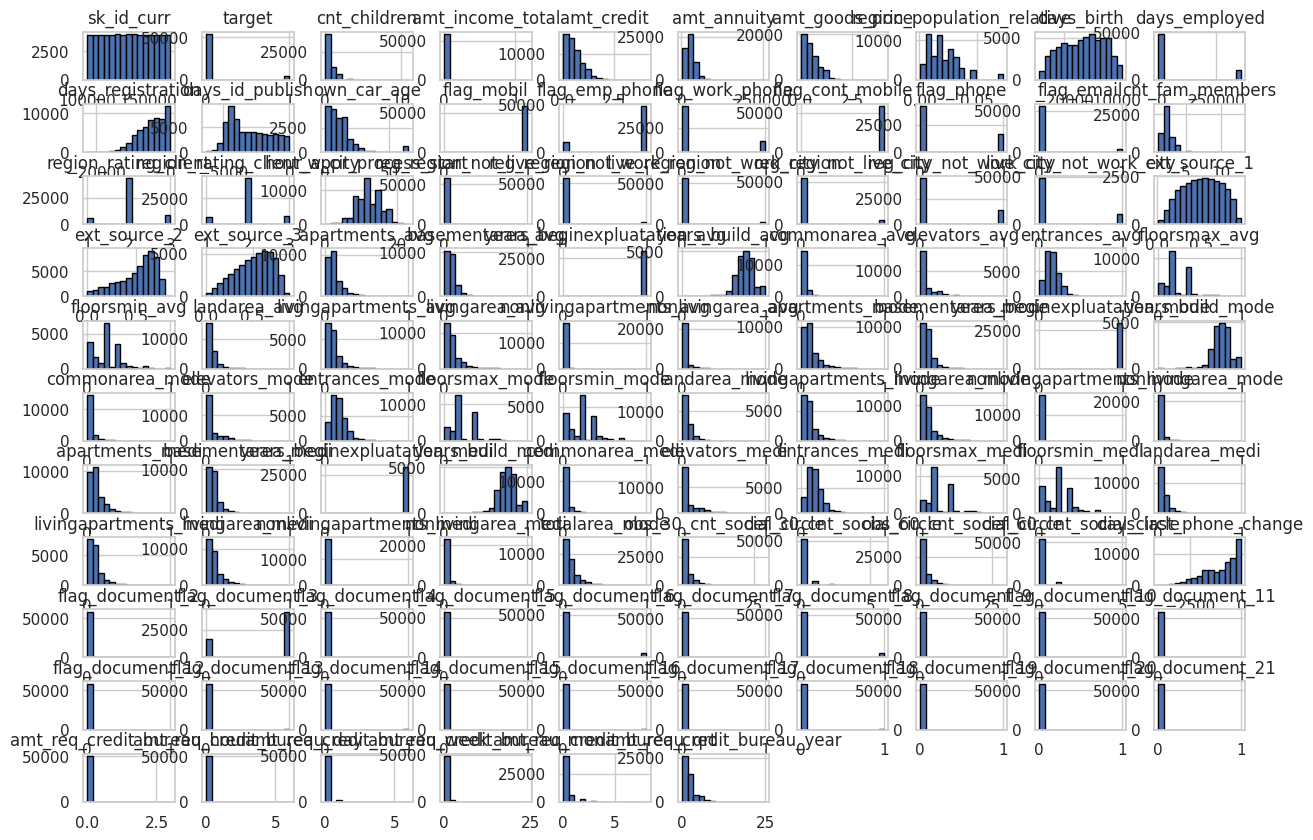

In [7]:
loan_applications.hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.subplots_adjust(hspace=0.5)

Pair Plot for selected features

Text(0.5, 0.98, 'Pairwise Plots of Key Features')

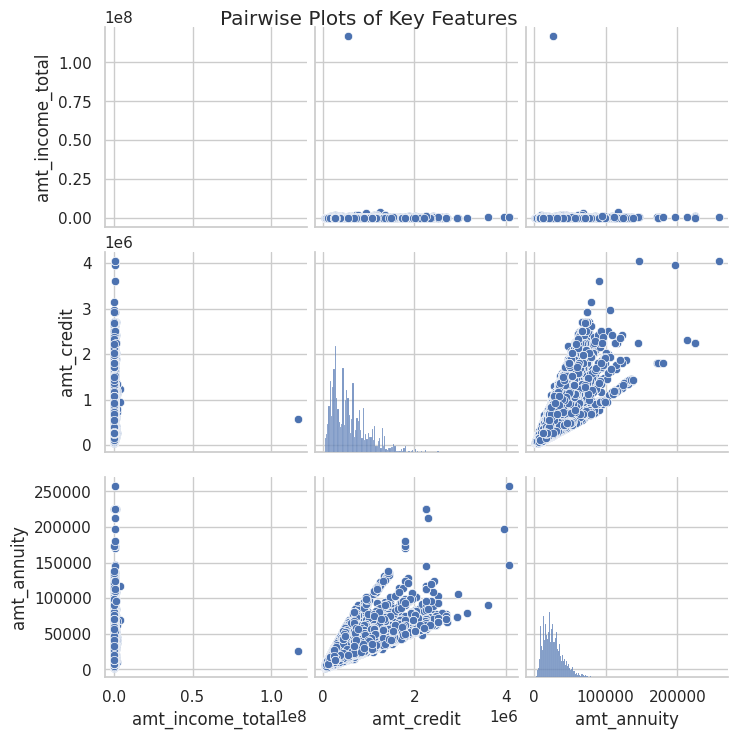

In [8]:
selected_features = ['amt_income_total', 'amt_credit', 'amt_annuity']
sns.pairplot(loan_applications[selected_features])
plt.suptitle('Pairwise Plots of Key Features')

Gender distribution

Text(0.5, 1.0, 'Gender Distribution')

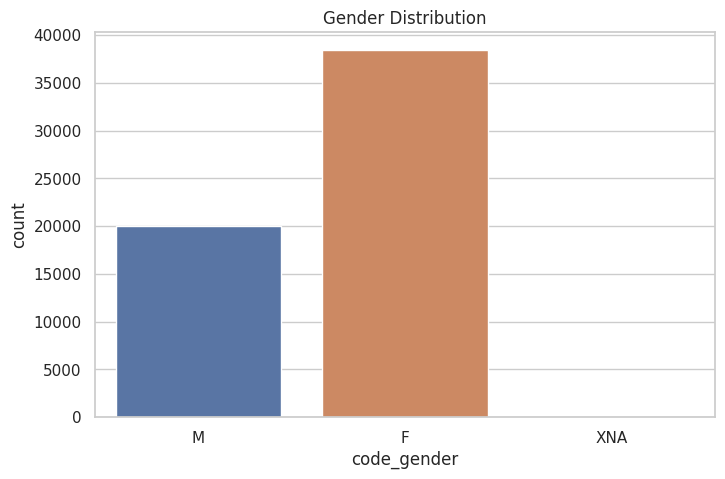

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x='code_gender', data=loan_applications)
plt.title('Gender Distribution')

Income distribution (with log transformation for better visualization)

<ipython-input-10-8b1a2af8b381>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log1p(loan_applications['amt_income_total']), kde=False)


Text(0, 0.5, 'Frequency')

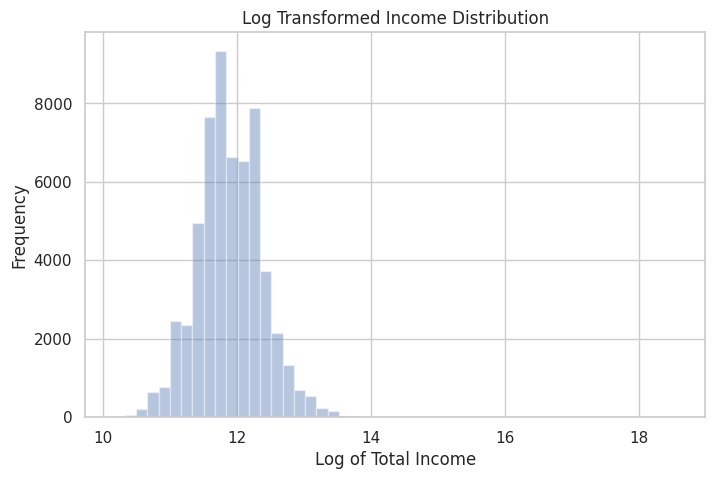

In [10]:
plt.figure(figsize=(8, 5))
sns.distplot(np.log1p(loan_applications['amt_income_total']), kde=False)
plt.title('Log Transformed Income Distribution')
plt.xlabel('Log of Total Income')
plt.ylabel('Frequency')

Boxplot for income by gender

Text(0.5, 1.0, 'Income Distribution by Gender')

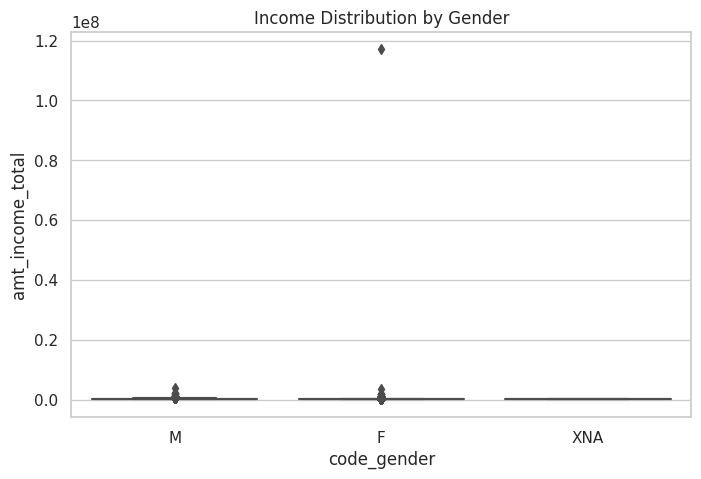

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='code_gender', y='amt_income_total', data=loan_applications)
plt.title('Income Distribution by Gender')

Correlation analysis with heatmap

<ipython-input-12-2530f96a7409>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = loan_applications.corr()


Text(0.5, 1.0, 'Correlation Matrix')

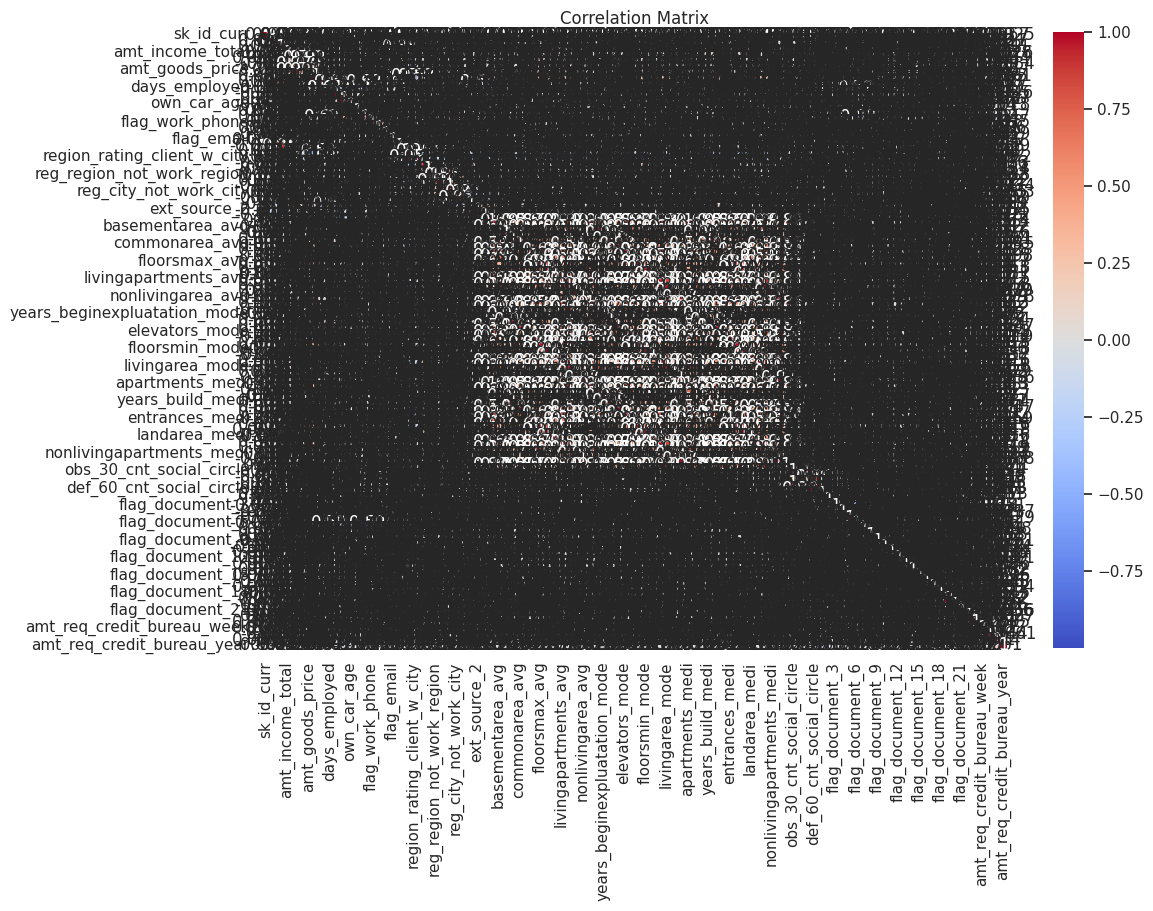

In [12]:
correlation_matrix = loan_applications.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

Income vs Loan Amount with Hue for Contract Type

Text(0, 0.5, 'Credit Amount')

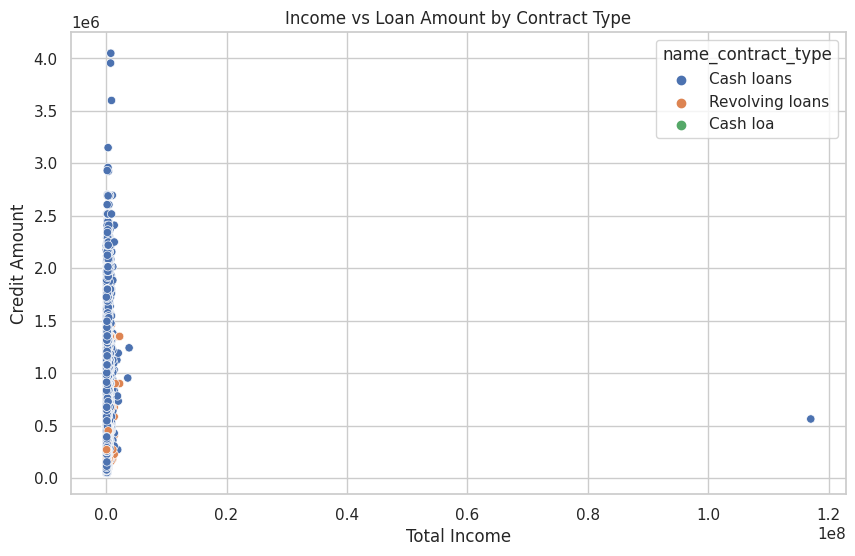

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='amt_income_total', y='amt_credit', hue='name_contract_type', data=loan_applications)
plt.title('Income vs Loan Amount by Contract Type')
plt.xlabel('Total Income')
plt.ylabel('Credit Amount')

Average income by contract type

In [14]:
avg_income_by_contract = loan_applications.groupby('name_contract_type')['amt_income_total'].mean()

KDE Plot of Age for different Contract Types

In [16]:
# plt.figure(figsize=(10, 6))
# for contract_type in loan_applications['name_contract_type'].unique():
#     subset = loan_applications[loan_applications['name_contract_type'] == contract_type]
#     sns.kdeplot(subset['age_years'], label=contract_type)
# plt.title('Age Distribution by Contract Type')
# plt.xlabel('Age in Years')
# plt.ylabel('Density')

Z-Score for Income, for outlier detection

In [17]:
loan_applications['income_z_score'] = np.abs(stats.zscore(loan_applications['amt_income_total']))
outliers = loan_applications[loan_applications['income_z_score'] > 3]
outliers

Empty DataFrame
Columns: [sk_id_curr, target, name_contract_type, code_gender, flag_own_car, flag_own_realty, cnt_children, amt_income_total, amt_credit, amt_annuity, amt_goods_price, name_type_suite, name_income_type, name_education_type, name_family_status, name_housing_type, region_population_relative, days_birth, days_employed, days_registration, days_id_publish, own_car_age, flag_mobil, flag_emp_phone, flag_work_phone, flag_cont_mobile, flag_phone, flag_email, occupation_type, cnt_fam_members, region_rating_client, region_rating_client_w_city, weekday_appr_process_start, hour_appr_process_start, reg_region_not_live_region, reg_region_not_work_region, live_region_not_work_region, reg_city_not_live_city, reg_city_not_work_city, live_city_not_work_city, organization_type, ext_source_1, ext_source_2, ext_source_3, apartments_avg, basementarea_avg, years_beginexpluatation_avg, years_build_avg, commonarea_avg, elevators_avg, entrances_avg, floorsmax_avg, floorsmin_avg, landarea_avg, livingapartments_avg, livingarea_avg, nonlivingapartments_avg, nonlivingarea_avg, apartments_mode, basementarea_mode, years_beginexpluatation_mode, years_build_mode, commonarea_mode, elevators_mode, entrances_mode, floorsmax_mode, floorsmin_mode, landarea_mode, livingapartments_mode, livingarea_mode, nonlivingapartments_mode, nonlivingarea_mode, apartments_medi, basementarea_medi, years_beginexpluatation_medi, years_build_medi, commonarea_medi, elevators_medi, entrances_medi, floorsmax_medi, floorsmin_medi, landarea_medi, livingapartments_medi, livingarea_medi, nonlivingapartments_medi, nonlivingarea_medi, fondkapremont_mode, housetype_mode, totalarea_mode, wallsmaterial_mode, emergencystate_mode, obs_30_cnt_social_circle, def_30_cnt_social_circle, obs_60_cnt_social_circle, def_60_cnt_social_circle, days_last_phone_change, flag_document_2, flag_document_3, flag_document_4, flag_document_5, ...]
Index: []

[0 rows x 123 columns]

##### Data Cleaning and Feature Engineering

In [23]:
# # Using SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# numerical_cols = loan_applications.select_dtypes(include=[np.number]).columns
# loan_applications[numerical_cols] = imputer.fit_transform(loan_applications[numerical_cols])

In [24]:
# Handling missing values for categorical columns with mode imputation
categorical_cols = loan_applications.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    loan_applications[col].fillna(loan_applications[col].mode()[0], inplace=True)

In [25]:
# Handling missing values for categorical columns with mode imputation
categorical_cols = loan_applications.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    loan_applications[col].fillna(loan_applications[col].mode()[0], inplace=True)

In [26]:
# Feature Engineering

# Income Ratios
loan_applications['credit_income_ratio'] = loan_applications['amt_credit'] / loan_applications['amt_income_total']
loan_applications['annuity_income_ratio'] = loan_applications['amt_annuity'] / loan_applications['amt_income_total']
loan_applications['goods_price_income_ratio'] = loan_applications['amt_goods_price'] / loan_applications['amt_income_total']

# Career Ratio
loan_applications['employment_ratio'] = loan_applications['days_employed'] / loan_applications['days_birth']
loan_applications['employment_ratio'] = loan_applications['employment_ratio'].replace([np.inf, -np.inf], np.nan)

# Family Features
loan_applications['adults_ratio'] = (loan_applications['cnt_fam_members'] - loan_applications['cnt_children']) / loan_applications['cnt_fam_members']

# Number of Overall Payments
loan_applications['payment_rate'] = loan_applications['amt_credit'] / loan_applications['amt_annuity'].replace({0: np.nan})

# External Source Features
loan_applications['ext_sources_mean'] = loan_applications[['ext_source_1', 'ext_source_2', 'ext_source_3']].mean(axis=1)
loan_applications['ext_sources_nanmean'] = loan_applications[['ext_source_1', 'ext_source_2', 'ext_source_3']].apply(lambda x: np.nanmean(x), axis=1)

# Number of Documents Submitted
doc_vars = ["flag_document_" + str(i) for i in range(2, 22)]
loan_applications['doc_count'] = loan_applications[doc_vars].sum(axis=1)

# Logarithm Transformation of Skewed Features
skewed_cols = ['amt_credit', 'amt_income_total', 'amt_goods_price', 'amt_annuity']
for col in skewed_cols:
    loan_applications['log_' + col] = np.log1p(loan_applications[col])

# Convert Days to Years
days_cols = ['days_birth', 'days_employed', 'days_registration', 'days_id_publish', 'days_last_phone_change']
for col in days_cols:
    loan_applications[col + '_years'] = np.abs(loan_applications[col]) / 365

# Age-Related Ratios
loan_applications['car_age_ratio'] = loan_applications['own_car_age'] / loan_applications['days_birth']
loan_applications['phone_change_ratio'] = loan_applications['days_last_phone_change'] / loan_applications['days_birth']


<ipython-input-26-6b4aef17523c>:20: RuntimeWarning: Mean of empty slice
  loan_applications['ext_sources_nanmean'] = loan_applications[['ext_source_1', 'ext_source_2', 'ext_source_3']].apply(lambda x: np.nanmean(x), axis=1)


In [27]:
# # One-Hot Encoding for categorical variables
# ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
# encoded_features = ohe.fit_transform(loan_applications[categorical_cols])
# encoded_features_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(categorical_cols))
# loan_applications = loan_applications.drop(columns=categorical_cols).join(encoded_features_df)

In [28]:
# Winsorization to cap outliers
for col in numerical_cols:
    loan_applications[col] = winsorize(loan_applications[col], limits=[0.05, 0.05])

In [29]:
# important_features = loan_applications.columns.drop('target')
# # Feature Selection using RandomForest (Assuming a target variable exists)
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(loan_applications[important_features], loan_applications['target'])
# importances = rf.feature_importances_
# important_features = [feature for feature, importance in zip(important_features, importances) if importance > np.mean(importances)]

In [30]:
# # Final dataset with selected important features
# loan_applications = loan_applications[important_features + ['target']]

# # Display the first few rows of the processed dataset
# loan_applications

In [31]:
loan_applications.isnull().sum().sum()

1689568

# 2. Credit History Section

In [32]:
# Handling missing values for numerical columns
num_imputer = SimpleImputer(strategy='mean')
numerical_cols_prev = previous_credits.select_dtypes(include=[np.number]).columns
previous_credits[numerical_cols_prev] = num_imputer.fit_transform(previous_credits[numerical_cols_prev])

In [33]:
# Handling missing values for categorical columns
categorical_cols = previous_credits.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    previous_credits[col].fillna(previous_credits[col].mode()[0], inplace=True)

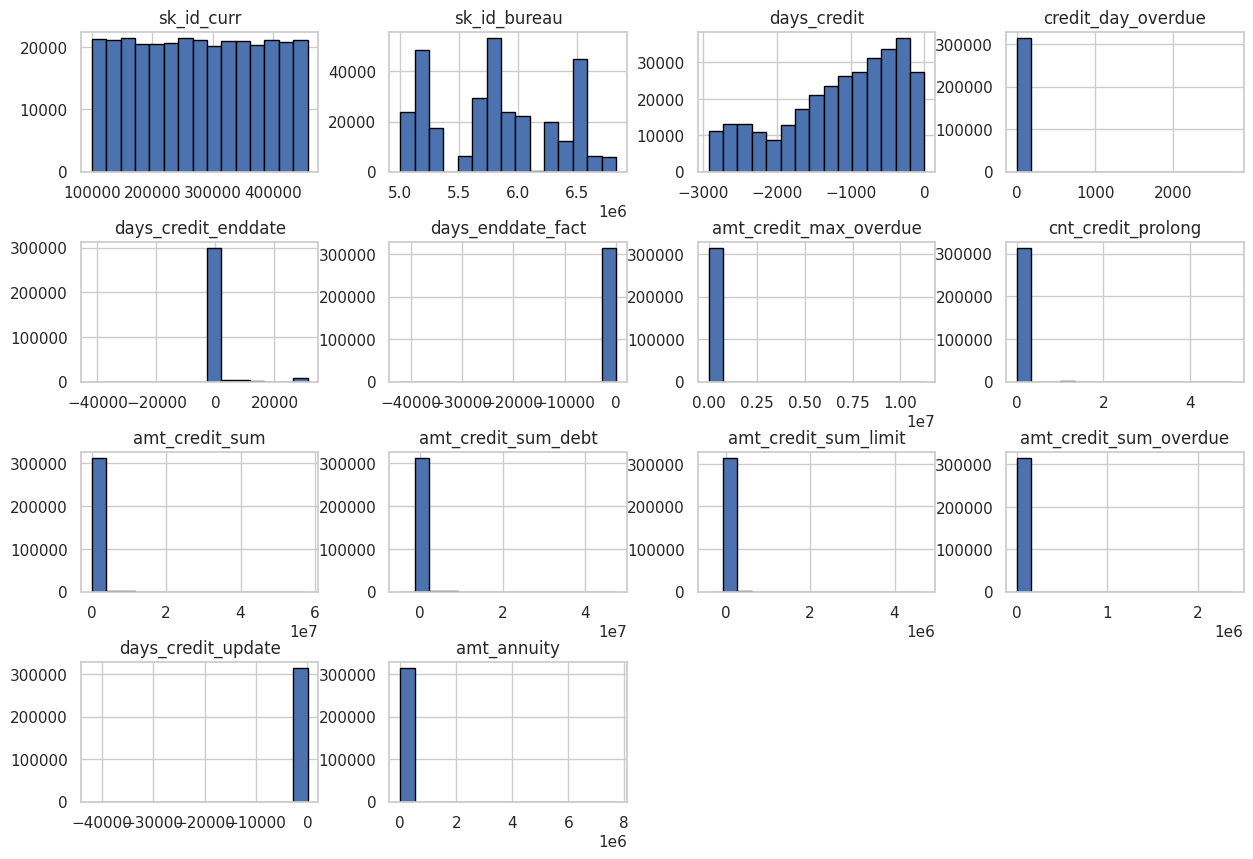

In [34]:
# Distribution of key numerical features for previous_credits
previous_credits.hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.subplots_adjust(hspace=0.5)

In [35]:
# Handling missing values for numerical columns
num_imputer = SimpleImputer(strategy='mean')
numerical_cols_bur = credit_bureau_balance.select_dtypes(include=[np.number]).columns
credit_bureau_balance[numerical_cols_bur] = num_imputer.fit_transform(credit_bureau_balance[numerical_cols_bur])

In [36]:
# Handling missing values for categorical columns
categorical_cols = credit_bureau_balance.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    credit_bureau_balance[col].fillna(credit_bureau_balance[col].mode()[0], inplace=True)

In [37]:
# merging data fror this section
cred_histo = pd.merge(previous_credits, credit_bureau_balance, on='sk_id_bureau', how='left')

Text(0.5, 1.0, 'Average Credit Amount by Credit Status and Activity')

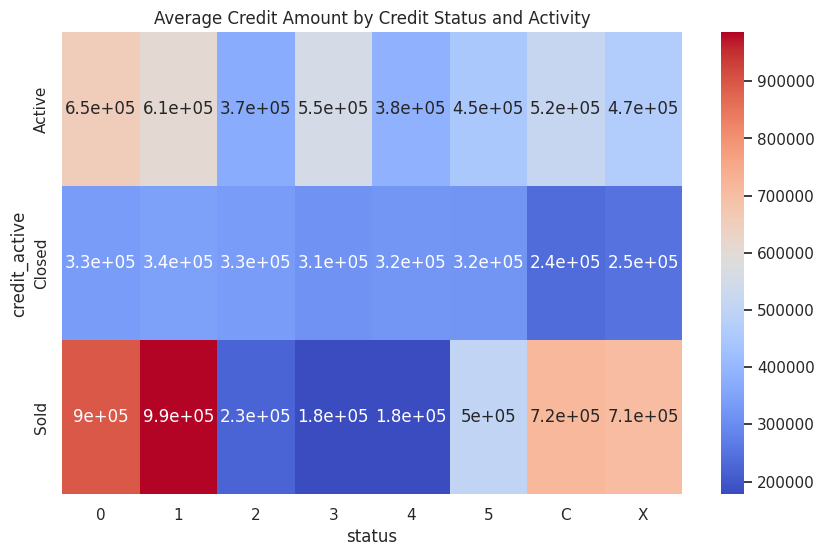

In [38]:
# Heatmap for Credit Amount vs. Status
pivot_table = cred_histo.pivot_table(values='amt_credit_sum', index='credit_active', columns='status', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title('Average Credit Amount by Credit Status and Activity')

<ipython-input-39-6b816e0c7ae4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = cred_histo.corr()


Text(0.5, 1.0, 'Correlation Matrix')

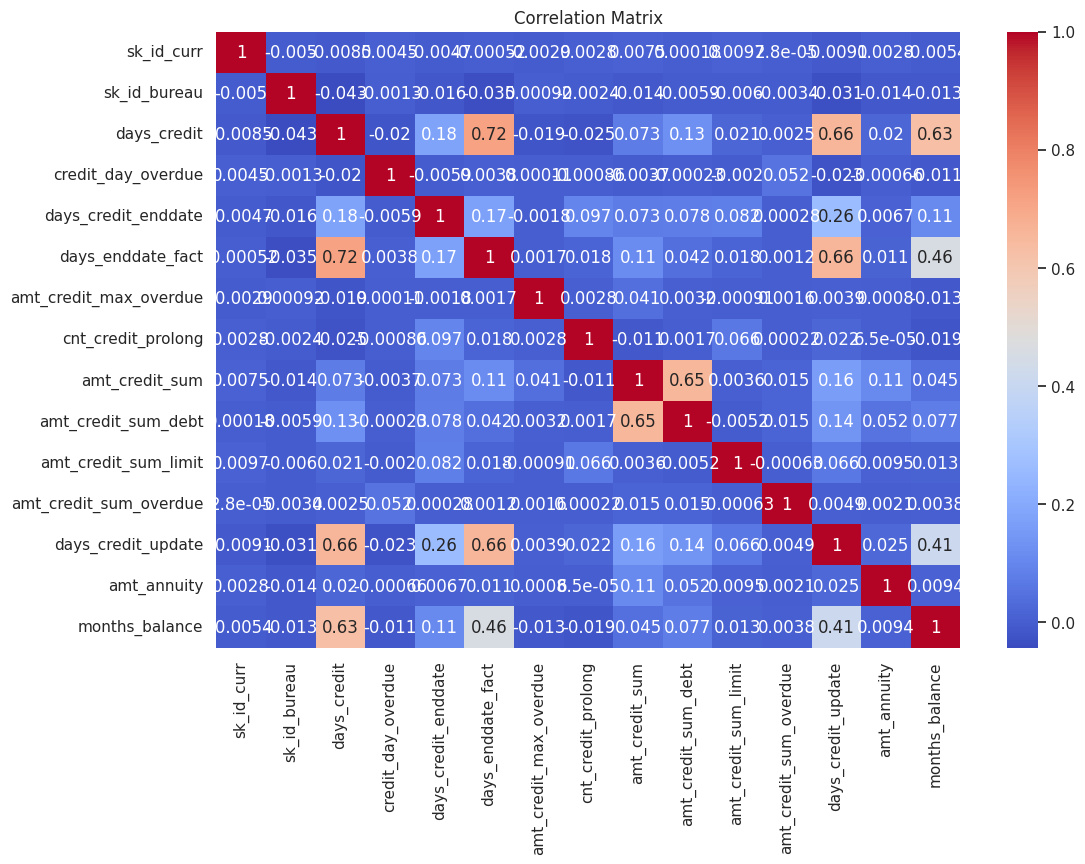

In [39]:
# Correlation analysis
correlation_matrix = cred_histo.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

In [40]:
# Average credit amount by credit type
avg_credit_by_type = cred_histo.groupby('credit_type')['amt_credit_sum'].mean()

# Total credit amount by credit active status
total_credit_by_status = cred_histo.groupby('credit_active')['amt_credit_sum'].sum()

# Count of credits by credit type and active status
count_credits = cred_histo.groupby(['credit_type', 'credit_active']).size().reset_index(name='count')

# Average monthly balance by status
avg_monthly_balance_by_status = credit_bureau_balance.groupby('status')['months_balance'].mean()

# Maximum overdue amount in credit bureau data
max_overdue = previous_credits.groupby('sk_id_bureau')['amt_credit_max_overdue'].max()

# Multi-level aggregation
agg_data = previous_credits.groupby('credit_active').agg({'amt_credit_sum': 'mean',
                                                         'amt_credit_max_overdue': 'max'}).reset_index()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'Another type of loan'),
  Text(1, 0, 'Car loan'),
  Text(2, 0, 'Cash loan (non-earmarked)'),
  Text(3, 0, 'Consumer credit'),
  Text(4, 0, 'Credit card'),
  Text(5, 0, 'Loan for business development'),
  Text(6, 0, 'Loan for the purchase of equipment'),
  Text(7, 0, 'Loan for working capital replenishment'),
  Text(8, 0, 'Microloan'),
  Text(9, 0, 'Mobile operator loan'),
  Text(10, 0, 'Mortgage'),
  Text(11, 0, 'Real estate loan'),
  Text(12, 0, 'Unknown type of loan')])

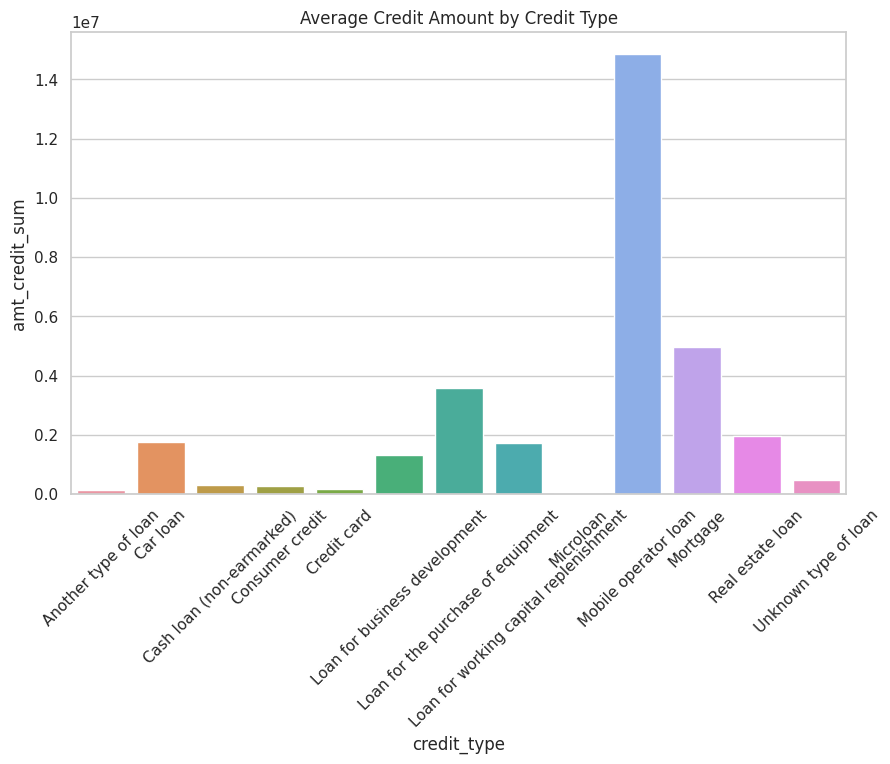

In [41]:
# Bar plot for average credit by type
plt.figure(figsize=(10, 6))
sns.barplot(x='credit_type', y='amt_credit_sum', data=avg_credit_by_type.reset_index())
plt.title('Average Credit Amount by Credit Type')
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'Another type of loan'),
  Text(1, 0, 'Car loan'),
  Text(2, 0, 'Cash loan (non-earmarked)'),
  Text(3, 0, 'Consumer credit'),
  Text(4, 0, 'Credit card'),
  Text(5, 0, 'Loan for business development'),
  Text(6, 0, 'Loan for the purchase of equipment'),
  Text(7, 0, 'Loan for working capital replenishment'),
  Text(8, 0, 'Microloan'),
  Text(9, 0, 'Mobile operator loan'),
  Text(10, 0, 'Mortgage'),
  Text(11, 0, 'Real estate loan'),
  Text(12, 0, 'Unknown type of loan')])

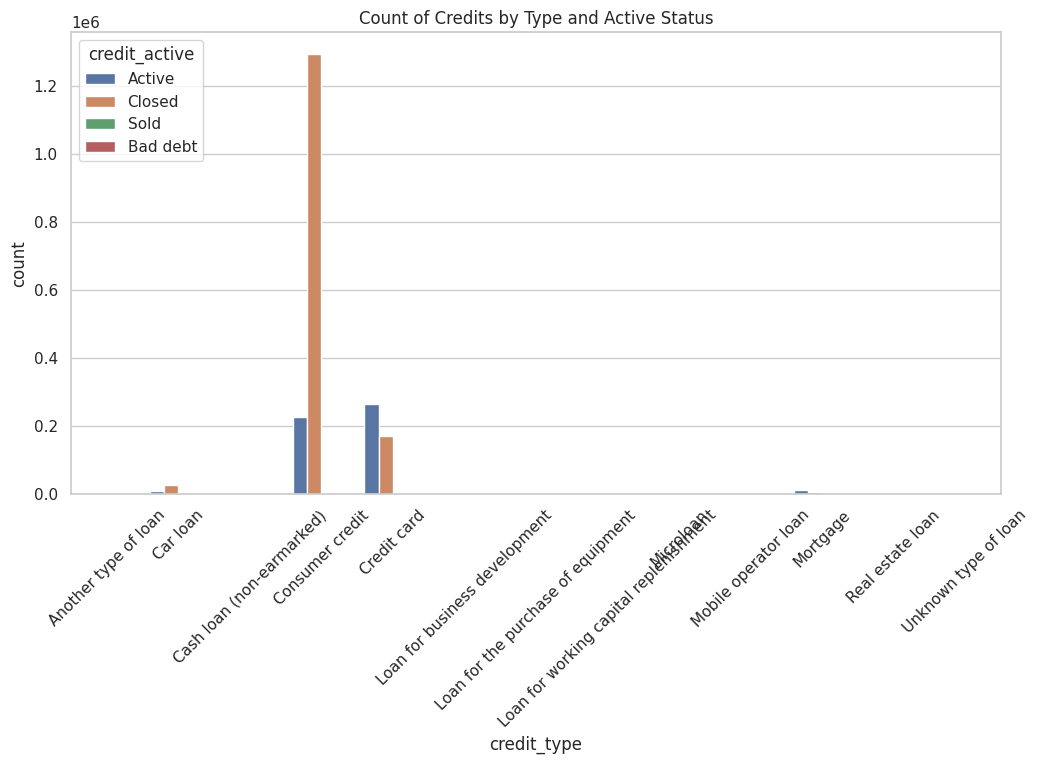

In [42]:
# Bar plot for count of credits
plt.figure(figsize=(12, 6))
sns.barplot(x='credit_type', y='count', hue='credit_active', data=count_credits)
plt.title('Count of Credits by Type and Active Status')
plt.xticks(rotation=45)

In [43]:
# using Z-score for Credit Amount, for outlier detection
cred_histo['credit_amount_z_score'] = np.abs(stats.zscore(cred_histo['amt_credit_sum']))
outliers = cred_histo[cred_histo['credit_amount_z_score'] > 3]

##### Data cleaning and Feature engineering

In [44]:
# # One-Hot Encoding for categorical variables
# ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
# encoded_features = ohe.fit_transform(cred_histo[categorical_cols])
# encoded_features_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(categorical_cols))
# cred_histo = cred_histo.drop(columns=categorical_cols).join(encoded_features_df)

In [45]:
# Winsorization to cap outliers in numerical columns
for col in numerical_cols_prev:
    cred_histo[col] = winsorize(cred_histo[col], limits=[0.05, 0.05])

for col in numerical_cols_bur:
    cred_histo[col] = winsorize(cred_histo[col], limits=[0.05, 0.05])

In [46]:
cred_histo.columns

Index(['sk_id_curr', 'sk_id_bureau', 'credit_active', 'credit_currency',
       'days_credit', 'credit_day_overdue', 'days_credit_enddate',
       'days_enddate_fact', 'amt_credit_max_overdue', 'cnt_credit_prolong',
       'amt_credit_sum', 'amt_credit_sum_debt', 'amt_credit_sum_limit',
       'amt_credit_sum_overdue', 'credit_type', 'days_credit_update',
       'amt_annuity', 'months_balance', 'status', 'credit_amount_z_score'],
      dtype='object')

In [47]:
# Feature Engineering on cred_histo data
# Replace 'X' with None and encode other statuses as increasing integers
cred_histo['status'].replace({'X': None, 'C': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6}, inplace=True)
# Calculate loan score
cred_histo['loan_score'] = cred_histo['status'] / (abs(cred_histo['months_balance']) + 1)
loan_score = cred_histo.groupby('sk_id_bureau')['loan_score'].sum().rename('loan_score').reset_index()

# Merge the loan score into cred_histo
cred_histo = cred_histo.merge(loan_score, on='sk_id_bureau', how='left')

# Encoding categorical 'status' into dummy variables
cred_histo = pd.get_dummies(cred_histo, columns=['status'], prefix='status')

In [48]:
cred_histo.columns

Index(['sk_id_curr', 'sk_id_bureau', 'credit_active', 'credit_currency',
       'days_credit', 'credit_day_overdue', 'days_credit_enddate',
       'days_enddate_fact', 'amt_credit_max_overdue', 'cnt_credit_prolong',
       'amt_credit_sum', 'amt_credit_sum_debt', 'amt_credit_sum_limit',
       'amt_credit_sum_overdue', 'credit_type', 'days_credit_update',
       'amt_annuity', 'months_balance', 'credit_amount_z_score',
       'loan_score_x', 'loan_score_y', 'status_0.0', 'status_1.0',
       'status_2.0', 'status_3.0', 'status_4.0', 'status_5.0', 'status_6.0'],
      dtype='object')

In [49]:


# Aggregate bureau balance data
cred_histo = cred_histo.groupby('sk_id_bureau').agg('mean')
cred_histo['MONTH_COUNT'] = cred_histo.groupby('sk_id_bureau')['months_balance'].count()


# Feature Engineering on cred_histo data
# Amount ratios
cred_histo['AMT_SUM_OVERDUE_RATIO'] = cred_histo['amt_credit_sum_overdue'] / cred_histo['amt_credit_sum']
cred_histo['AMT_MAX_OVERDUE_RATIO'] = cred_histo['amt_credit_max_overdue'] / cred_histo['amt_credit_sum']
cred_histo['AMT_SUM_DEBT_RATIO'] = cred_histo['amt_credit_sum_debt'] / cred_histo['amt_credit_sum']

# Log transformations
log_vars = ['amt_credit_sum', 'amt_credit_sum_debt', 'amt_credit_sum_limit', 'amt_credit_sum_overdue', 'amt_annuity']
for var in log_vars:
    cred_histo['log_' + var] = np.log1p(cred_histo[var])

# Convert days to positive values and years
days_cols = ['days_credit', 'credit_day_overdue', 'days_credit_enddate', 'days_enddate_fact', 'days_credit_update']
for col in days_cols:
    cred_histo[col] = np.abs(cred_histo[col]) / 365

# Detect and handle outliers for 'amt_credit_sum'
z_scores = np.abs(stats.zscore(cred_histo['amt_credit_sum']))
cred_histo['amt_credit_sum'] = np.where(z_scores > 3, cred_histo['amt_credit_sum'].median(), cred_histo['amt_credit_sum'])

# Aggregate features
agg_features = {
    'amt_credit_sum': ['mean', 'sum', 'max'],
    'amt_credit_sum_debt': ['mean', 'sum', 'max'],
    'amt_credit_sum_overdue': ['mean', 'sum', 'max'],
    'amt_annuity': ['mean', 'sum', 'max'],
    'sk_id_curr': ['size']
}

cred_histo = cred_histo.groupby('sk_id_curr').agg(agg_features)
cred_histo.columns = ['_'.join(col).upper() for col in cred_histo.columns.values]


<ipython-input-49-762cbc1e6219>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cred_histo = cred_histo.groupby('sk_id_bureau').agg('mean')


In [50]:
cred_histo.columns

Index(['AMT_CREDIT_SUM_MEAN', 'AMT_CREDIT_SUM_SUM', 'AMT_CREDIT_SUM_MAX',
       'AMT_CREDIT_SUM_DEBT_MEAN', 'AMT_CREDIT_SUM_DEBT_SUM',
       'AMT_CREDIT_SUM_DEBT_MAX', 'AMT_CREDIT_SUM_OVERDUE_MEAN',
       'AMT_CREDIT_SUM_OVERDUE_SUM', 'AMT_CREDIT_SUM_OVERDUE_MAX',
       'AMT_ANNUITY_MEAN', 'AMT_ANNUITY_SUM', 'AMT_ANNUITY_MAX',
       'SK_ID_CURR_SIZE'],
      dtype='object')

In [51]:
loan_applications = loan_applications.merge(right = cred_histo, how="left", on = "sk_id_curr")
del cred_histo

<ipython-input-51-ebc6c0d2ed07>:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  loan_applications = loan_applications.merge(right = cred_histo, how="left", on = "sk_id_curr")


# 3. Bank X loan history section

In [52]:
bank_loan_hist = pd.merge(previous_loan_applications, repayment_history, on='sk_id_curr', how='inner')

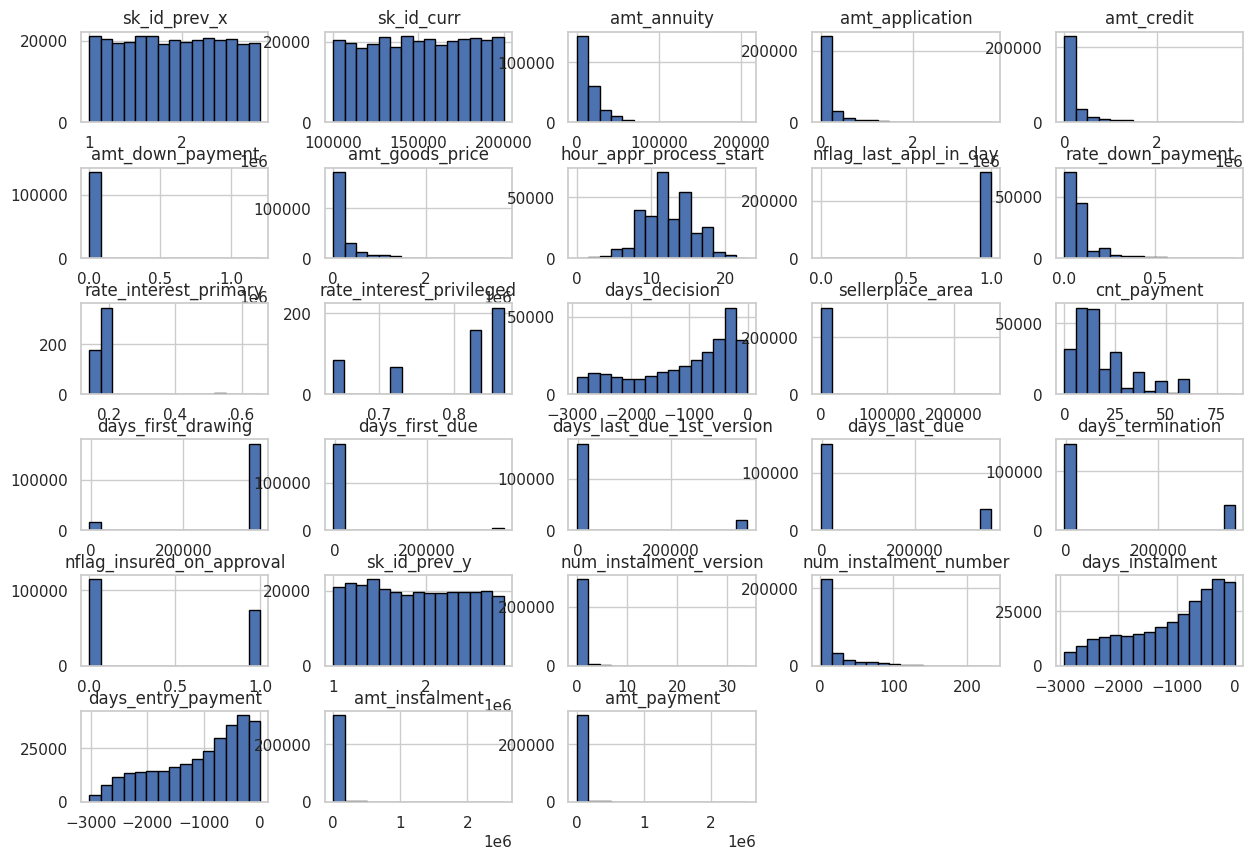

In [53]:
# Distribution of key numerical features
bank_loan_hist.hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.subplots_adjust(hspace=0.5)

<ipython-input-54-1d7e1941582f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bank_loan_hist['amt_credit'], bins=30, kde=False)


Text(0.5, 1.0, 'Distribution of Loan Amounts')

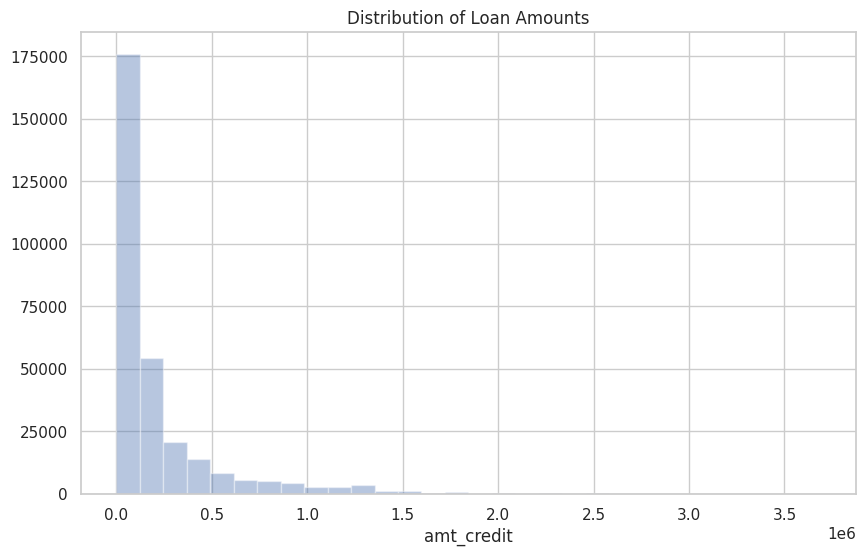

In [54]:
#Loan Amount Distribution
plt.figure(figsize=(10, 6))
sns.distplot(bank_loan_hist['amt_credit'], bins=30, kde=False)
plt.title('Distribution of Loan Amounts')

<ipython-input-56-7d8045ea99a0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = bank_loan_hist.corr()


Text(0.5, 1.0, 'Correlation Matrix')

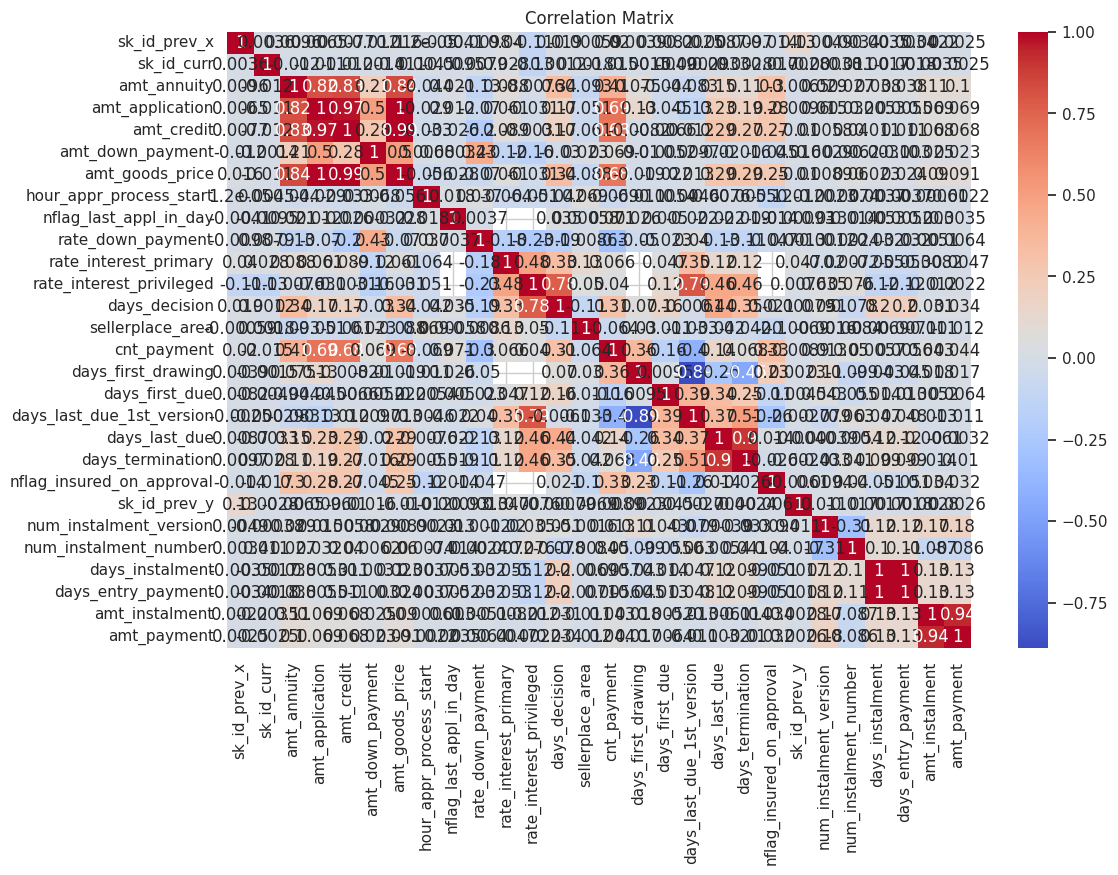

In [56]:
# Correlation analysis
correlation_matrix = bank_loan_hist.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

In [57]:
# # Bar plot for average loan amount by status
# plt.figure(figsize=(10, 6))
# sns.barplot(x='name_contract_status', y='amt_credit', data=avg_loan_by_status.reset_index())
# plt.title('Average Loan Amount by Contract Status')
# plt.xticks(rotation=45)

In [58]:
# # Bar plot for total payment by loan type
# plt.figure(figsize=(12, 6))
# sns.barplot(x='name_contract_type', y='amt_payment', data=total_payment_by_type.reset_index())
# plt.title('Total Payment by Loan Type')
# plt.xticks(rotation=45)

In [59]:
# detecting outliers, using z-score
bank_loan_hist['loan_amount_z_score'] = np.abs(stats.zscore(bank_loan_hist['amt_credit']))
outliers = bank_loan_hist[bank_loan_hist['loan_amount_z_score'] > 3]
outliers

sk_id_prev_x  sk_id_curr name_contract_type   amt_annuity  \
1190         2610268      153188         Cash loans  35920.261719   
1191         2610268      153188         Cash loans  35920.261719   
1192         2610268      153188         Cash loans  35920.261719   
1193         2610268      153188         Cash loans  35920.261719   
1194         2610268      153188         Cash loans  35920.261719   
...              ...         ...                ...           ...   
302199       1753704      146825         Cash loans  32556.599609   
302200       1753704      146825         Cash loans  32556.599609   
302201       1753704      146825         Cash loans  32556.599609   
302202       1753704      146825         Cash loans  32556.599609   
302203       1753704      146825         Cash loans  32556.599609   

        amt_application  amt_credit  amt_down_payment  amt_goods_price  \
1190          1224000.0   1224000.0               NaN        1224000.0   
1191          1224000.0   1224000.0               NaN        1224000.0   
1192          1224000.0   1224000.0               NaN        1224000.0   
1193          1224000.0   1224000.0               NaN        1224000.0   
1194          1224000.0   1224000.0               NaN        1224000.0   
...                 ...         ...               ...              ...   
302199        1125000.0   1288350.0               NaN        1125000.0   
302200        1125000.0   1288350.0               NaN        1125000.0   
302201        1125000.0   1288350.0               NaN        1125000.0   
302202        1125000.0   1288350.0               NaN        1125000.0   
302203        1125000.0   1288350.0               NaN        1125000.0   

       weekday_appr_process_start  hour_appr_process_start  ...  \
1190                       MONDAY                       19  ...   
1191                       MONDAY                       19  ...   
1192                       MONDAY                       19  ...   
1193                       MONDAY                       19  ...   
1194                       MONDAY                       19  ...   
...                           ...                      ...  ...   
302199                   THURSDAY                       14  ...   
302200                   THURSDAY                       14  ...   
302201                   THURSDAY                       14  ...   
302202                   THURSDAY                       14  ...   
302203                   THURSDAY                       14  ...   

       days_termination  nflag_insured_on_approval  sk_id_prev_y  \
1190           365243.0                        0.0       1181397   
1191           365243.0                        0.0       2610268   
1192           365243.0                        0.0       1181397   
1193           365243.0                        0.0       2598373   
1194           365243.0                        0.0       2630257   
...                 ...                        ...           ...   
302199              NaN                        NaN       2490708   
302200              NaN                        NaN       2332683   
302201              NaN                        NaN       1429890   
302202              NaN                        NaN       2490708   
302203              NaN                        NaN       1429890   

        num_instalment_version  num_instalment_number days_instalment  \
1190                       0.0                   44.0          -309.0   
1191                       3.0                    6.0           -86.0   
1192                       0.0                   49.0          -245.0   
1193                       1.0                    5.0          -811.0   
1194                       2.0                    9.0         -2009.0   
...                        ...                    ...             ...   
302199                     1.0                   22.0          -236.0   
302200                     1.0                    8.0         -1157.0   
302201     

In [60]:
del bank_loan_hist

##### Data cleaning and Feature engineering

In [61]:
# Feature Engineering for Repayment History
repayment_history['DPD'] = repayment_history['days_entry_payment'] - repayment_history['days_instalment']
repayment_history['DBD'] = repayment_history['days_instalment'] - repayment_history['days_entry_payment']
repayment_history['DPD'] = repayment_history['DPD'].apply(lambda x: x if x > 0 else 0)
repayment_history['DBD'] = repayment_history['DBD'].apply(lambda x: x if x > 0 else 0)

# Percentage and difference paid in each installment
repayment_history['PAYMENT_PERC'] = repayment_history['amt_payment'] / repayment_history['amt_instalment']
repayment_history['PAYMENT_DIFF'] = repayment_history['amt_instalment'] - repayment_history['amt_payment']

# Logarithmic transformation
repayment_history['log_amt_instalment'] = np.log1p(repayment_history['amt_instalment'])
repayment_history['log_amt_payment'] = np.log1p(repayment_history['amt_payment'])

# Count of installments
inst_count = repayment_history.groupby('sk_id_prev')['num_instalment_number'].nunique().reset_index()
inst_count.rename(columns={'num_instalment_number': 'NUM_INSTALMENT_COUNT'}, inplace=True)

# Merge count of installments back to the repayment history
# Make sure to drop duplicates from inst_count if 'sk_id_prev' is not unique
inst_count = inst_count.drop_duplicates(subset=['sk_id_prev'])
repayment_history = repayment_history.merge(inst_count, on='sk_id_prev', how='left')

#  perform the loan-level aggregation and flatten the MultiIndex columns
agg_repayment_history_loan = repayment_history.groupby('sk_id_prev').agg({
    'DPD': ['mean', 'max'],
    'DBD': ['mean', 'max'],
    'PAYMENT_PERC': ['mean', 'min', 'max'],
    'PAYMENT_DIFF': ['mean', 'sum'],
    'log_amt_instalment': ['mean', 'max'],
    'log_amt_payment': ['mean', 'max'],
}).reset_index()

# Flatten MultiIndex columns
agg_repayment_history_loan.columns = ['_'.join(col).strip() for col in agg_repayment_history_loan.columns.values]

agg_repayment_history_loan.rename(columns={"sk_id_prev_": "sk_id_prev"}, inplace=True)

# Merge with the original loan_applications DataFrame to get 'sk_id_curr'
agg_repayment_history_loan = agg_repayment_history_loan.merge(repayment_history[['sk_id_prev', 'sk_id_curr']], on='sk_id_prev', how='left')

# Now perform customer-level aggregation using the correct column names
agg_repayment_history_customer = agg_repayment_history_loan.groupby('sk_id_curr').agg({
    'DPD_mean': 'mean',
    'DPD_max': 'max',
    'DBD_mean': 'mean',
    'DBD_max': 'max',
    'PAYMENT_PERC_mean': 'mean',
    'PAYMENT_PERC_min': 'min',
    'PAYMENT_PERC_max': 'max',
    'PAYMENT_DIFF_mean': 'mean',
    'PAYMENT_DIFF_sum': 'sum',
    'log_amt_instalment_mean': 'mean',
    'log_amt_instalment_max': 'max',
    'log_amt_payment_mean': 'mean',
    'log_amt_payment_max': 'max',
}).reset_index()

# Merge the aggregated customer level data back to the main dataframe
loan_applications = loan_applications.merge(agg_repayment_history_customer, on='sk_id_curr', how='left')


In [62]:
del agg_repayment_history_customer

In [63]:
# Feature Engineering for previous_loan_applications DataFrame

# Amount ratios
previous_loan_applications["AMT_GIVEN_RATIO_1"] = previous_loan_applications["amt_credit"] / previous_loan_applications["amt_application"]
previous_loan_applications["AMT_GIVEN_RATIO_2"] = previous_loan_applications["amt_goods_price"] / previous_loan_applications["amt_application"]
previous_loan_applications["DOWN_PAYMENT_RATIO"] = previous_loan_applications["amt_down_payment"] / previous_loan_applications["amt_application"]

# Logarithmic transformations
log_vars = ["amt_credit", "amt_annuity", "amt_application", "amt_down_payment", "amt_goods_price"]
for var in log_vars:
    previous_loan_applications['log_' + var] = np.log1p(previous_loan_applications[var].replace(0, np.nan))

# Convert days to positive values
day_vars = ["days_first_drawing", "days_first_due", "days_last_due_1st_version",
            "days_last_due", "days_termination", "days_decision"]
for col in day_vars:
    previous_loan_applications[col] = np.abs(previous_loan_applications[col])

# Count number of previous applications and contracts
cnt_prev_applications = previous_loan_applications.groupby('sk_id_curr')['sk_id_prev'].count().reset_index()
cnt_prev_applications.rename(columns={'sk_id_prev': 'CNT_PREV_APPLICATIONS'}, inplace=True)
previous_loan_applications = previous_loan_applications.merge(cnt_prev_applications, on='sk_id_curr', how='left')

cnt_prev_contracts = previous_loan_applications[previous_loan_applications['flag_last_appl_per_contract'] == "Y"]
cnt_prev_contracts = cnt_prev_contracts.groupby('sk_id_curr')['flag_last_appl_per_contract'].count().reset_index()
cnt_prev_contracts.rename(columns={'flag_last_appl_per_contract': 'CNT_PREV_CONTRACTS'}, inplace=True)
previous_loan_applications = previous_loan_applications.merge(cnt_prev_contracts, on='sk_id_curr', how='left')

# Ratio of number of applications to contracts
previous_loan_applications["APPL_PER_CONTRACT_RATIO"] = previous_loan_applications["CNT_PREV_APPLICATIONS"] / previous_loan_applications["CNT_PREV_CONTRACTS"]

# Day differences
previous_loan_applications["DAYS_DUE_DIFF_1"] = previous_loan_applications["days_last_due_1st_version"] - previous_loan_applications["days_first_due"]

# Encode the application day into a binary feature
previous_loan_applications["IS_WEEKEND_APPLICATION"] = previous_loan_applications["weekday_appr_process_start"].isin(["SATURDAY", "SUNDAY"]).astype(int)

# Drop features
drops = ["sk_id_prev"]
previous_loan_applications.drop(columns=drops, inplace=True)

# One-Hot Encoding for categorical variables
categorical_vars = previous_loan_applications.select_dtypes(include=['object', 'category']).columns
previous_loan_applications = pd.get_dummies(previous_loan_applications, columns=categorical_vars, drop_first=True)

# Aggregations for previous_loan_applications
agg_functions = {name: ['mean', 'max', 'min', 'sum'] for name in previous_loan_applications.columns if name not in ['sk_id_curr']}
agg_prev = previous_loan_applications.groupby('sk_id_curr').agg(agg_functions)
agg_prev.columns = ['_'.join(col).strip() for col in agg_prev.columns.values]

# Flatten MultiIndex columns and merge with the original DataFrame
agg_prev.reset_index(inplace=True)
final_prev_data = previous_loan_applications.merge(agg_prev, on='sk_id_curr', how='left')


<ipython-input-63-780fe469c351>:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_prev.reset_index(inplace=True)


In [64]:
loan_applications = loan_applications.merge(right = final_prev_data, how="left", on = "sk_id_curr")
del final_prev_data

# 4. Consumer Credit and Loan Products Section

In [65]:
# credit_loan = pd.merge(pos_cash_loans, credit_cards, on='sk_id_curr', how='inner')

In [66]:
# credit_loan.describe()

In [67]:
# # Distribution of key numerical features
# credit_loan.hist(bins=15, figsize=(15, 10), edgecolor='black')
# plt.subplots_adjust(hspace=0.5)

<ipython-input-68-db84665f9f52>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pos_cash_loans['cnt_instalment_future'], bins=30, kde=False)


Text(0.5, 1.0, 'Distribution of Future Installments Count in POS Cash Loans')

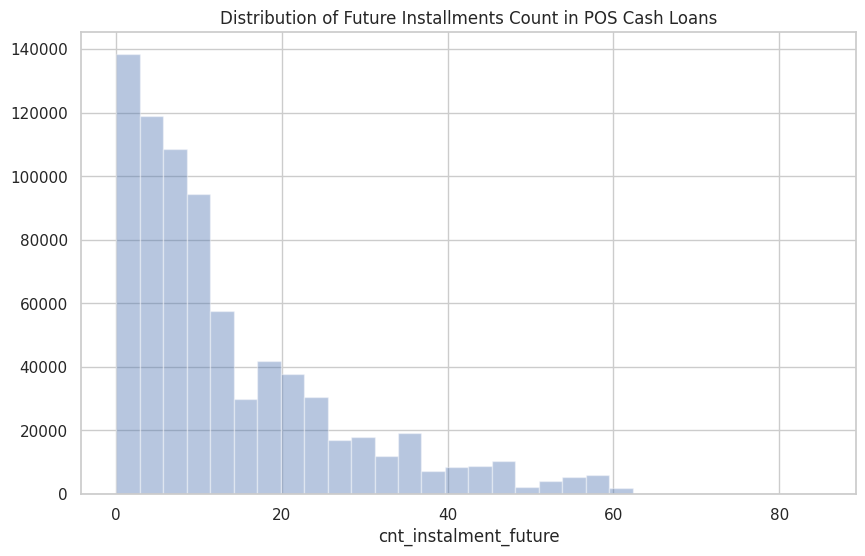

In [68]:
# Advanced Visualization: POS Cash Loan Amount Distribution
plt.figure(figsize=(10, 6))
sns.distplot(pos_cash_loans['cnt_instalment_future'], bins=30, kde=False)
plt.title('Distribution of Future Installments Count in POS Cash Loans')

In [69]:
# Average balance by contract status in credit cards
avg_balance_by_status = credit_cards.groupby('name_contract_status')['amt_balance'].mean()

# Total POS cash loan count by contract status
total_pos_count_by_status = pos_cash_loans.groupby('name_contract_status').size().reset_index(name='count')

# Multi-level aggregation
# Average balance and total credit limit by contract status in credit cards
agg_data = credit_cards.groupby('name_contract_status').agg({'amt_balance': 'mean',
                                                             'amt_credit_limit_actual': 'sum'}).reset_index()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Active'),
  Text(1, 0, 'Completed'),
  Text(2, 0, 'Demand'),
  Text(3, 0, 'Sent proposal'),
  Text(4, 0, 'Signed')])

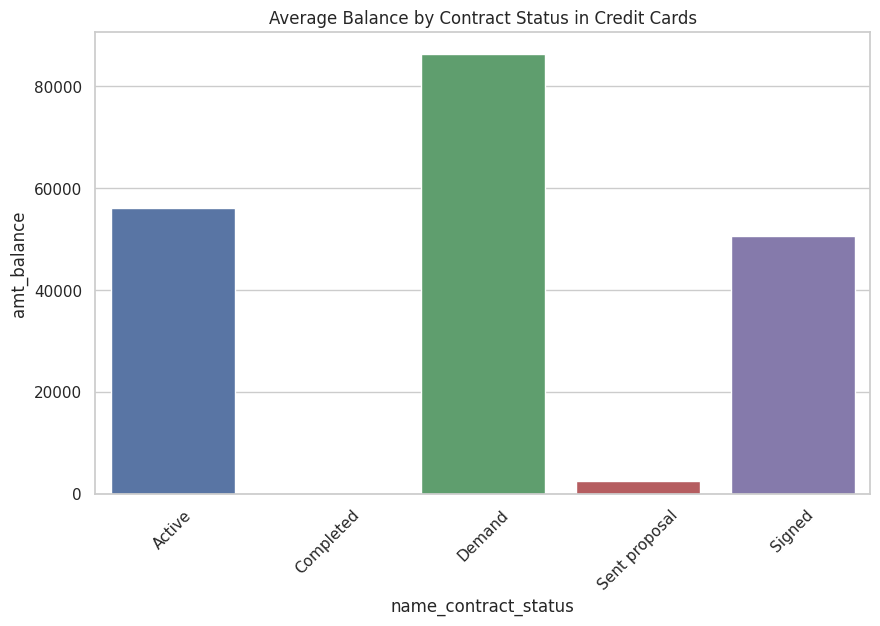

In [70]:
# Bar plot for average balance by contract status
plt.figure(figsize=(10, 6))
sns.barplot(x='name_contract_status', y='amt_balance', data=avg_balance_by_status.reset_index())
plt.title('Average Balance by Contract Status in Credit Cards')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Active'),
  Text(1, 0, 'Approved'),
  Text(2, 0, 'Completed'),
  Text(3, 0, 'Demand'),
  Text(4, 0, 'Returned to the store'),
  Text(5, 0, 'Signed')])

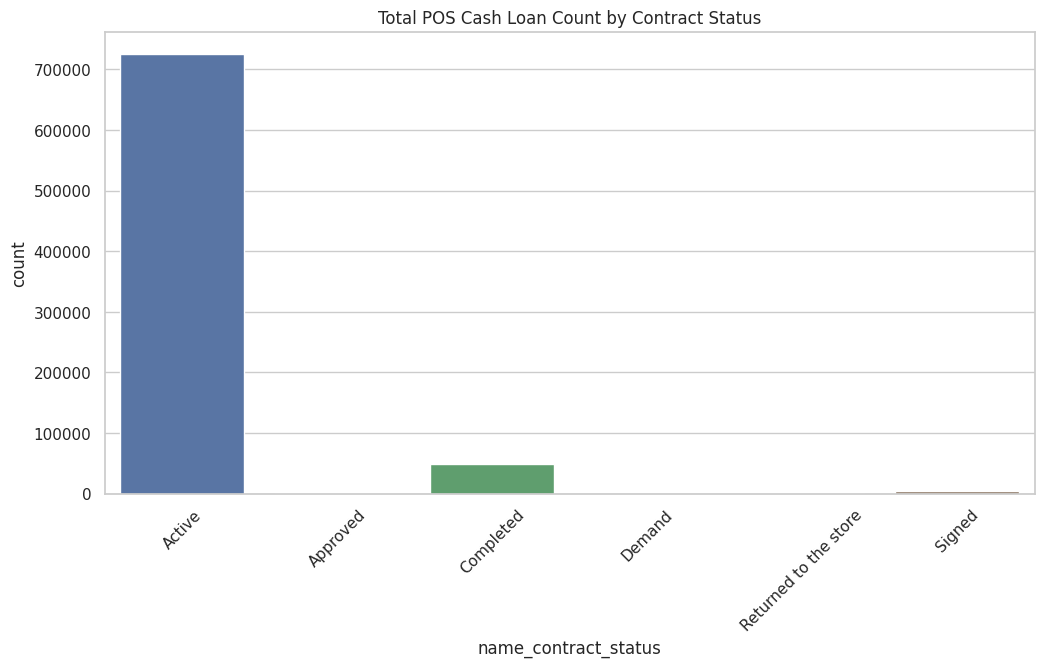

In [71]:
# Bar plot for total POS cash loan count by status
plt.figure(figsize=(12, 6))
sns.barplot(x='name_contract_status', y='count', data=total_pos_count_by_status)
plt.title('Total POS Cash Loan Count by Contract Status')
plt.xticks(rotation=45)

In [72]:
# outliers detections usgin z-score
credit_cards['balance_z_score'] = np.abs(stats.zscore(credit_cards['amt_balance']))
outliers = credit_cards[credit_cards['balance_z_score'] > 3]
outliers

Empty DataFrame
Columns: [sk_id_prev, sk_id_curr, months_balance, amt_balance, amt_credit_limit_actual, amt_drawings_atm_current, amt_drawings_current, amt_drawings_other_current, amt_drawings_pos_current, amt_inst_min_regularity, amt_payment_current, amt_payment_total_current, amt_receivable_principal, amt_recivable, amt_total_receivable, cnt_drawings_atm_current, cnt_drawings_current, cnt_drawings_other_current, cnt_drawings_pos_current, cnt_instalment_mature_cum, name_contract_status, sk_dpd, sk_dpd_def, balance_z_score]
Index: []

[0 rows x 24 columns]

##### Data cleaning and Feature engineering

In [76]:
credit_cards = pd.read_csv('previous_credit_cards.csv')

In [77]:
credit_cards = downcaste_dtype(credit_cards)

Memory usage before downcasting: 263.21 MB
After Downcasting the memory usage decreased to: 113.01 MB
Memory usage decreased by 57.065%


In [78]:
### AGGREGATIONS

# Count months
cnt_mon = credit_cards[['sk_id_prev', 'months_balance']].groupby('sk_id_prev').count()

# Handle 'SK_ID_CURR' and 'SK_ID_PREV'
credit_card_ids = credit_cards[['sk_id_curr', 'sk_id_prev']]
credit_cards.drop(['months_balance', 'sk_id_curr'], axis=1, inplace=True)

# Aggregate data
# First, separate numerical and categorical features
num_data = credit_cards.select_dtypes(include=[np.number])
fac_data = credit_cards.select_dtypes(exclude=[np.number])

# Ensure 'sk_id_prev' is present in both dataframes for grouping
if 'sk_id_prev' not in num_data.columns:
    num_data['sk_id_prev'] = credit_card_ids['sk_id_prev']

if 'sk_id_prev' not in fac_data.columns:
    fac_data['sk_id_prev'] = credit_card_ids['sk_id_prev']

# Aggregating numerical features
agg_num_data = num_data.groupby('sk_id_prev').agg(['mean', 'std', 'min', 'max'])
agg_num_data.columns = ["_".join(col).strip() for col in agg_num_data.columns.values]

# Aggregating categorical features
agg_fac_data = fac_data.groupby('sk_id_prev').agg([('mode', lambda x: x.mode()[0][0]),
                                                   ('unique', lambda x: x.nunique())])
agg_fac_data.columns = ["_".join(col).strip() for col in agg_fac_data.columns.values]

# Merge aggregated numerical and categorical data
agg_credit_cards = pd.concat([agg_num_data, agg_fac_data], axis=1)

# Add month count
agg_credit_cards['card_mon_count'] = cnt_mon['months_balance']

# Put back 'SK_ID_CURR'
credit_card_ids = credit_card_ids.drop_duplicates()
agg_credit_cards = credit_card_ids.merge(right=agg_credit_cards.reset_index(), how='right', on='sk_id_prev')

# Final aggregation based on 'SK_ID_CURR'
final_agg = agg_credit_cards.groupby('sk_id_curr').agg(['mean', 'std', 'min', 'max'])
final_agg.columns = ["card_" + "_".join(col).strip() for col in final_agg.columns.values]

# Clear memory
del credit_cards

<ipython-input-78-7c3e627e5564>:42: FutureWarning: ['name_contract_status_mode'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  final_agg = agg_credit_cards.groupby('sk_id_curr').agg(['mean', 'std', 'min', 'max'])


In [79]:
loan_applications = loan_applications.merge(right = final_agg, how="left", on = "sk_id_curr")
del final_agg


In [80]:

# Installments percentage
pos_cash_loans["inst"] = pos_cash_loans["cnt_instalment_future"] / pos_cash_loans["cnt_instalment"]

# Dummy encoding for categorical variables
pos_cash_loans = pd.get_dummies(pos_cash_loans, drop_first=True)

# Count missing values
nas = pos_cash_loans.isnull().sum().sort_values(ascending=False)
percent = (pos_cash_loans.isnull().sum() / pos_cash_loans.isnull().count() * 100).sort_values(ascending=False)
nas_table = pd.concat([nas, percent], axis=1, keys=["Total", "Percent"])
nas_table = nas_table[nas_table["Total"] > 0]

### AGGREGATIONS

# Count months
cnt_mon = pos_cash_loans[['sk_id_prev', 'months_balance']].groupby('sk_id_prev').count()

# Store IDs
pos_cash_loans_id = pos_cash_loans[['sk_id_curr', 'sk_id_prev']]

# Drop 'months_balance' and 'sk_id_curr'
pos_cash_loans.drop(['months_balance', 'sk_id_curr'], axis=1, inplace=True)

# Aggregate data
agg_pos_cash_loans = pos_cash_loans.groupby('sk_id_prev').mean()

# Add month count
agg_pos_cash_loans['poca_mon_count'] = cnt_mon['months_balance']

# Merge with 'SK_ID_CURR'
agg_pos_cash_loans.reset_index(inplace=True)
final_agg = pos_cash_loans_id.merge(agg_pos_cash_loans, on='sk_id_prev', how='right')

# Aggregate based on 'SK_ID_CURR'
final_agg = final_agg.groupby('sk_id_curr').mean()


# Clear memory
del pos_cash_loans


In [81]:
loan_applications = loan_applications.merge(right = final_agg, how="left", on = "sk_id_curr")
del final_agg

# Visualization and relations

In [82]:
# print(loan_applications.columns.tolist())

In [83]:
# loan_applications.to_csv("../DataSet/final_data.csv")

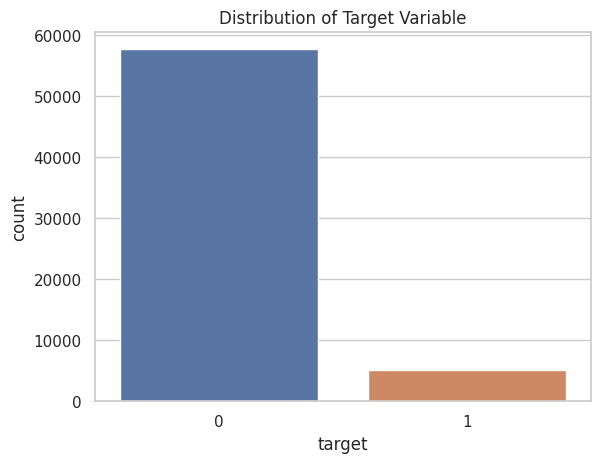

In [84]:
# Distribution of the Target Variable
sns.countplot(x='target', data=loan_applications)
plt.title('Distribution of Target Variable')
plt.show()


In [86]:
# # 2. Feature Importance using Random Forest
# features = [col for col in loan_applications.columns if col != 'target' and col != 'sk_id_curr']
# X = loan_applications[features]
# y = loan_applications['target']

# rf = RandomForestClassifier()
# rf.fit(X, y)
# importances = rf.feature_importances_
# indices = np.argsort(importances)[::-1]

# plt.figure(figsize=(15, 10))
# sns.barplot(x=X.columns[indices][:20], y=importances[indices][:20])
# plt.title('Top 20 Important Features')
# plt.xticks(rotation=45)
# plt.show()


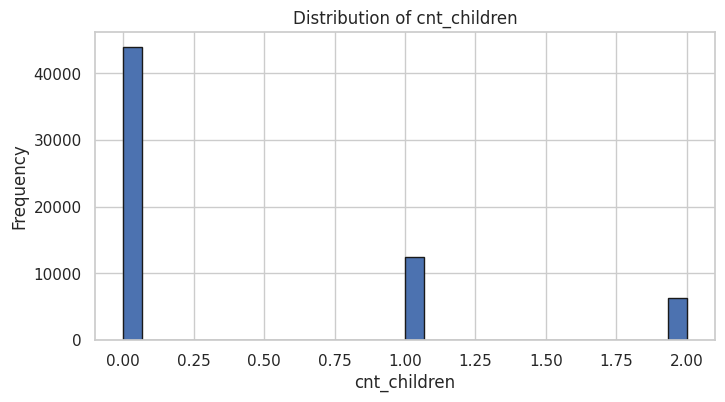

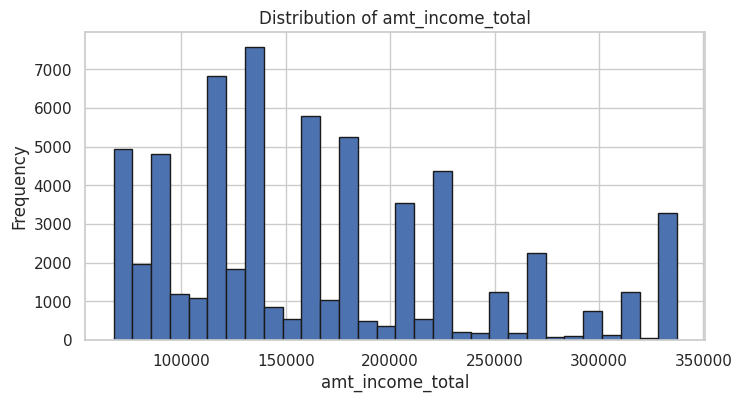

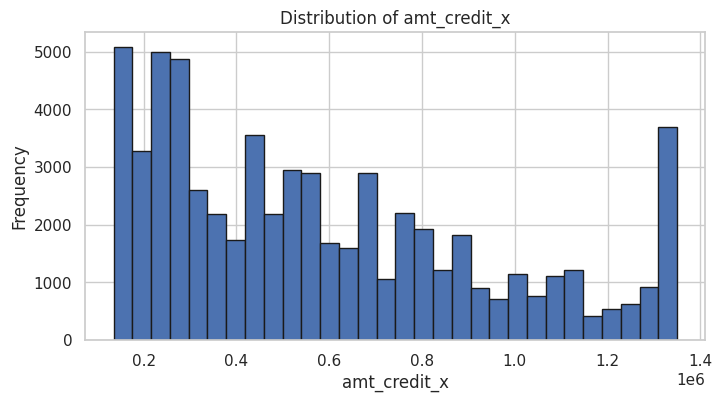

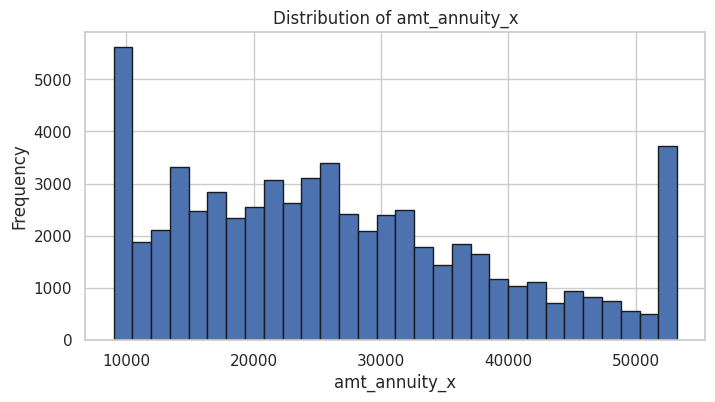

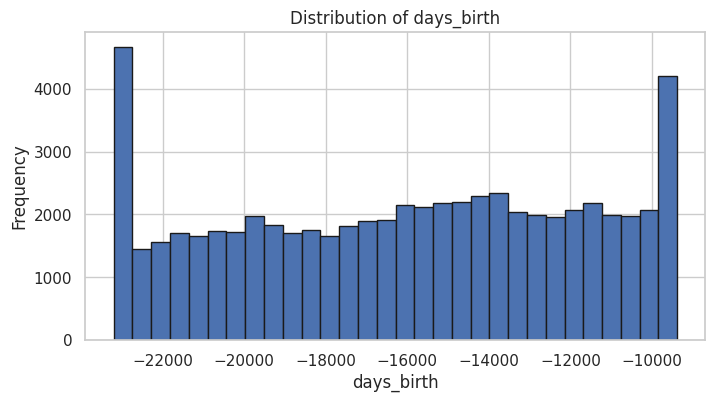

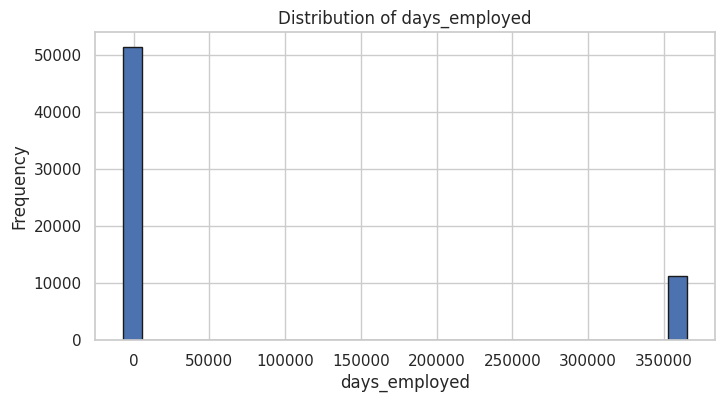

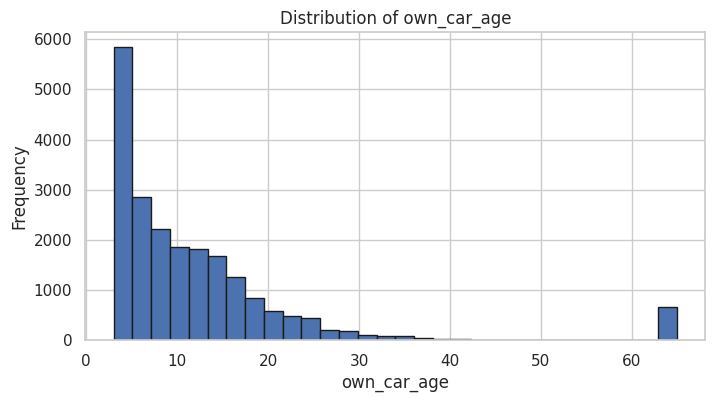

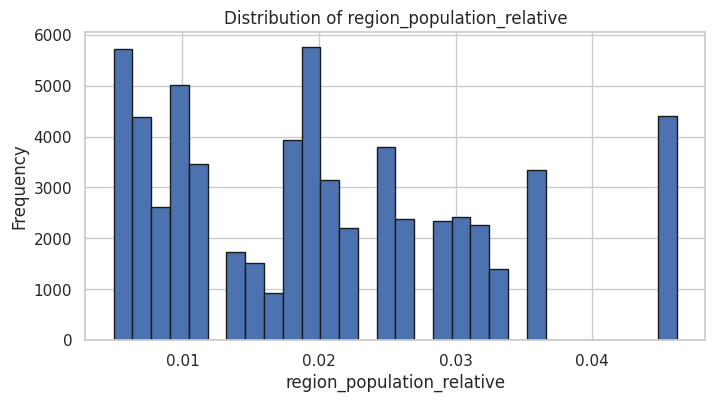

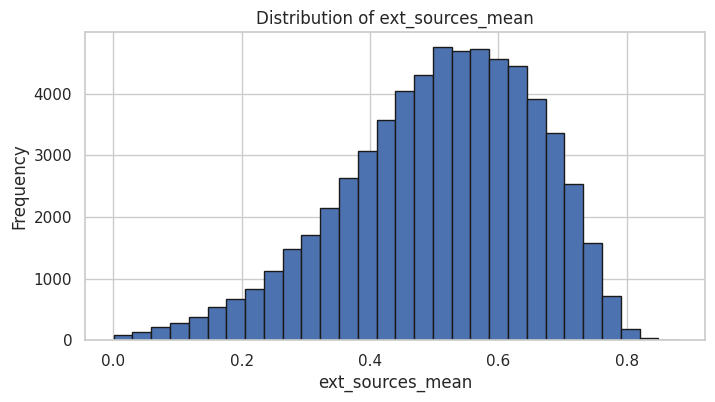

In [87]:
numerical_features = ['cnt_children', 'amt_income_total', 'amt_credit_x', 'amt_annuity_x', 'days_birth',
                      'days_employed', 'own_car_age', 'region_population_relative', 'ext_sources_mean']

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    plt.hist(loan_applications[feature].dropna(), bins=30, edgecolor='k')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

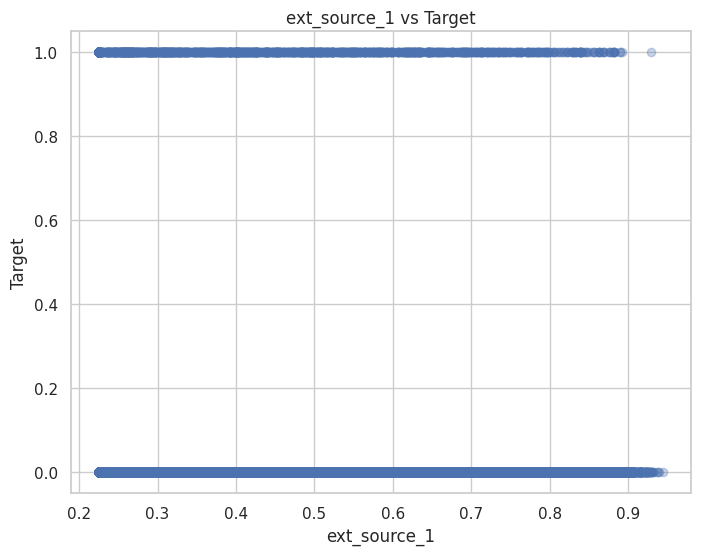

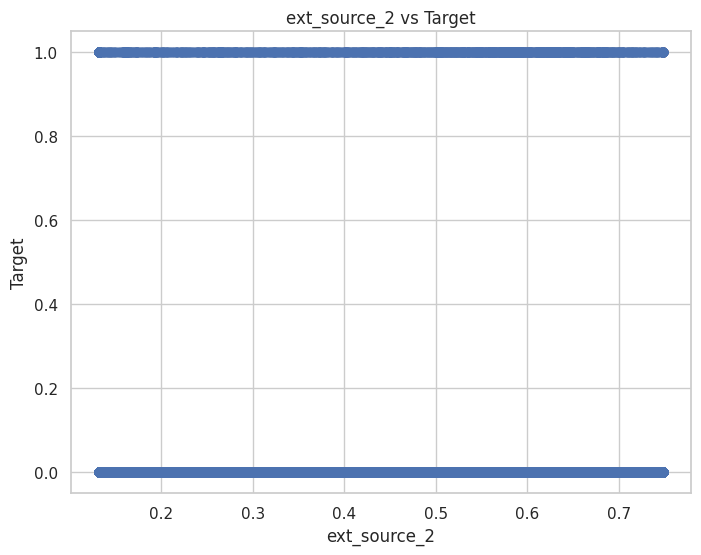

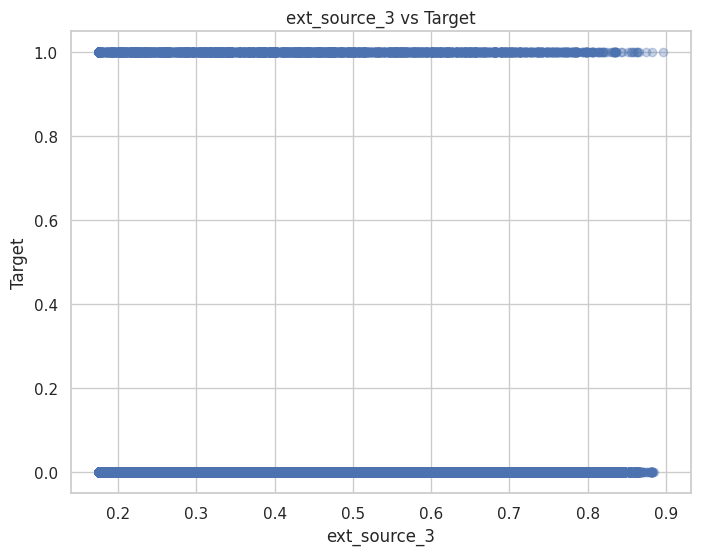

In [88]:
ext_source_features = ['ext_source_1', 'ext_source_2', 'ext_source_3']

for feature in ext_source_features:
    plt.figure(figsize=(8, 6))
    plt.scatter(loan_applications[feature], loan_applications['target'], alpha=0.3)
    plt.title(f'{feature} vs Target')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.show()


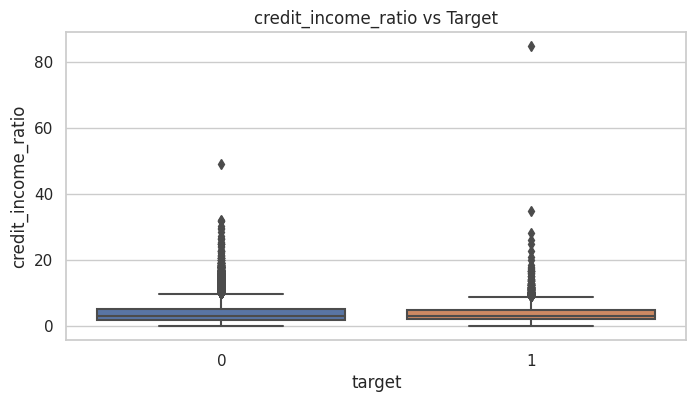

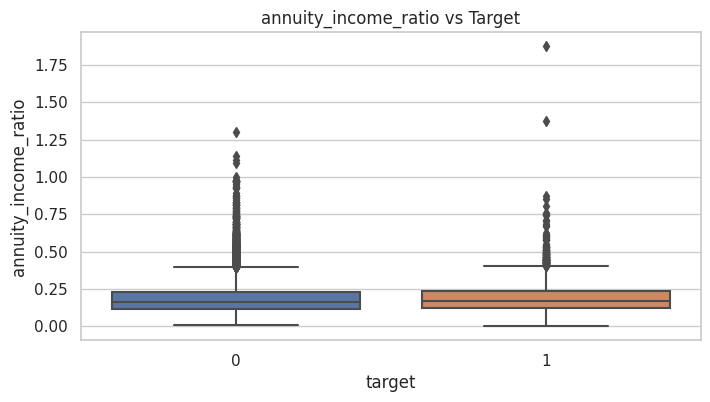

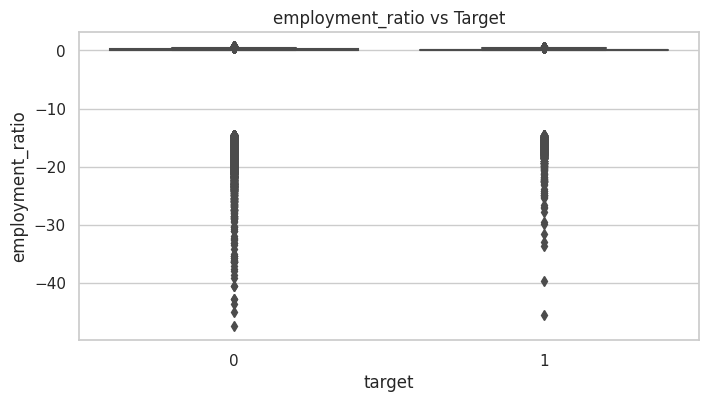

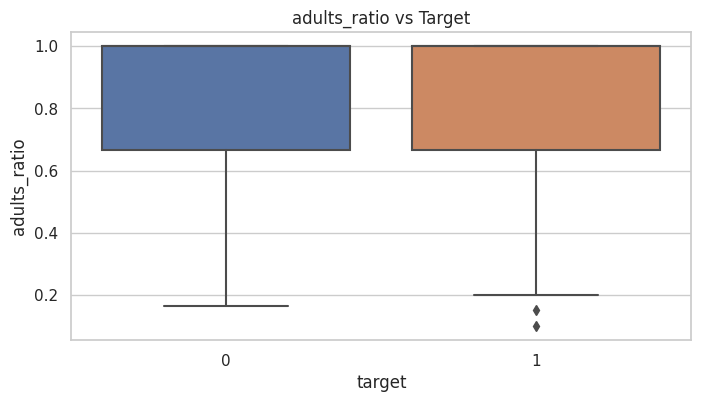

In [89]:
ratio_features = ['credit_income_ratio', 'annuity_income_ratio', 'employment_ratio', 'adults_ratio']

for feature in ratio_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='target', y=feature, data=loan_applications)
    plt.title(f'{feature} vs Target')
    plt.show()


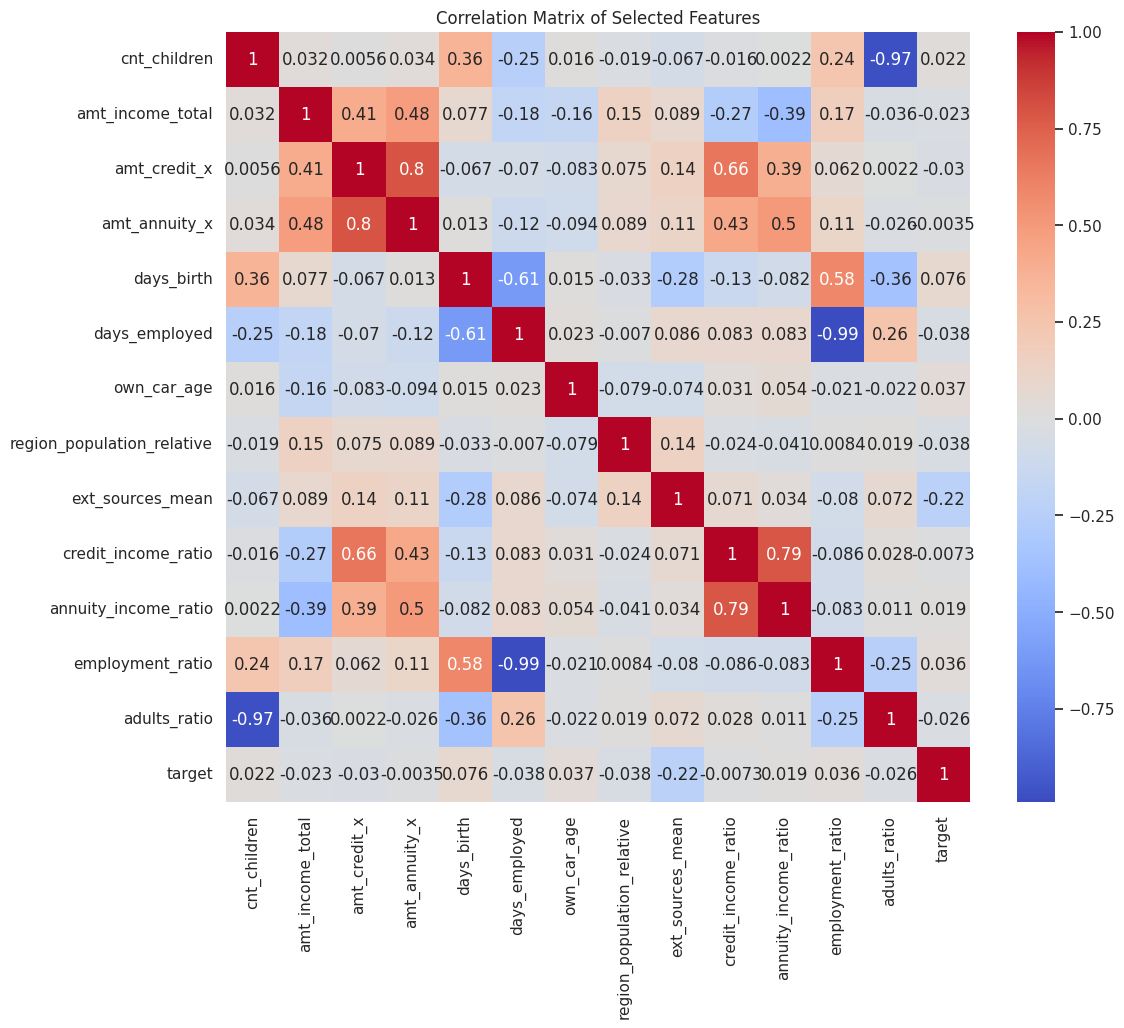

In [90]:
# Correlation with Target Variable
selected_features = numerical_features + ratio_features + ['target']
correlation_matrix = loan_applications[selected_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.show()


In [91]:
key_features = ['ext_sources_mean', 'credit_income_ratio', 'employment_ratio', 'amt_credit_x', 'amt_income_total']

In [93]:
# # 4. Pair Plots of Key Features

# sns.pairplot(loan_applications[key_features + ['target']], hue='target', plot_kws={'alpha': 0.5})
# plt.show()

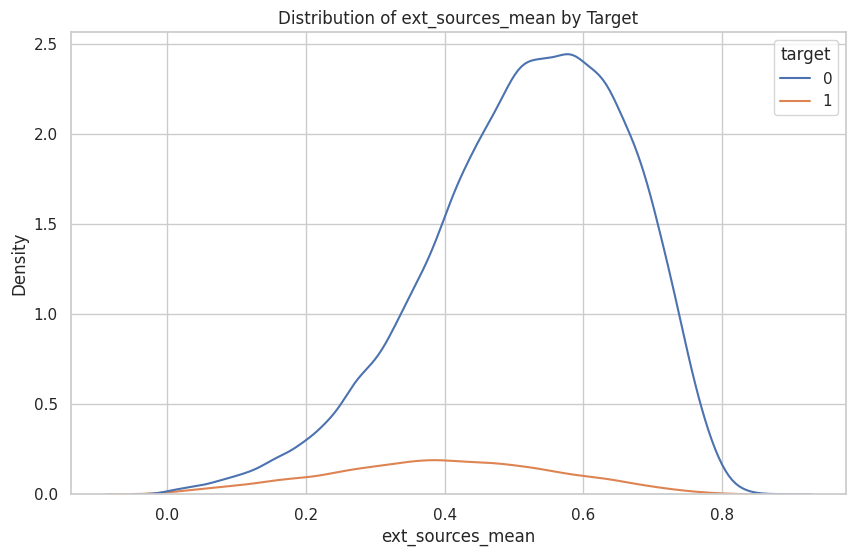

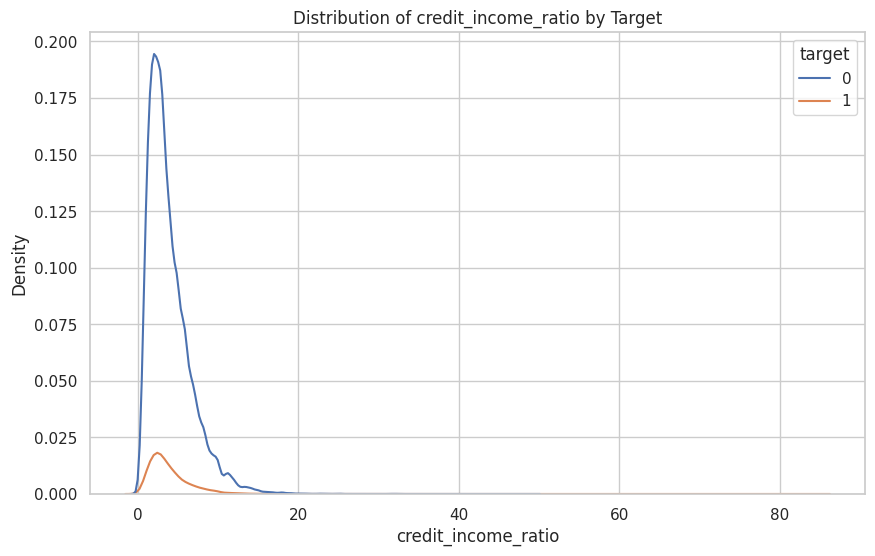

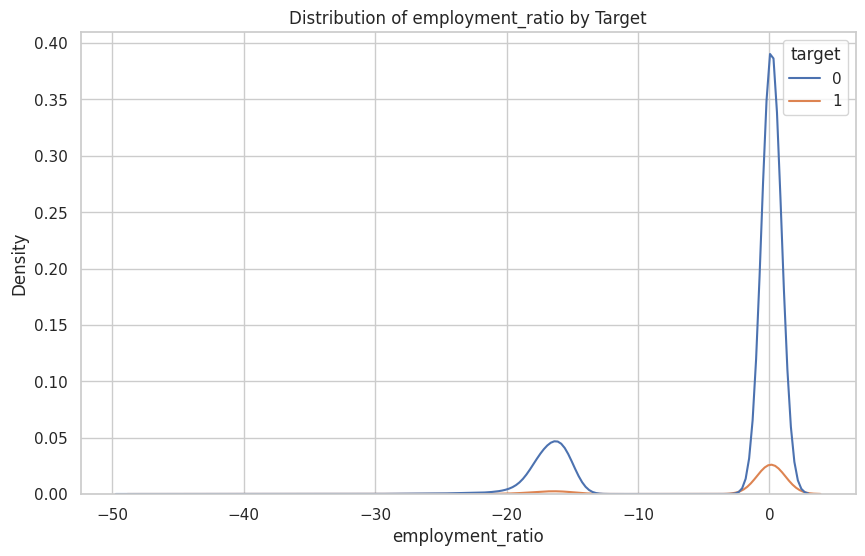

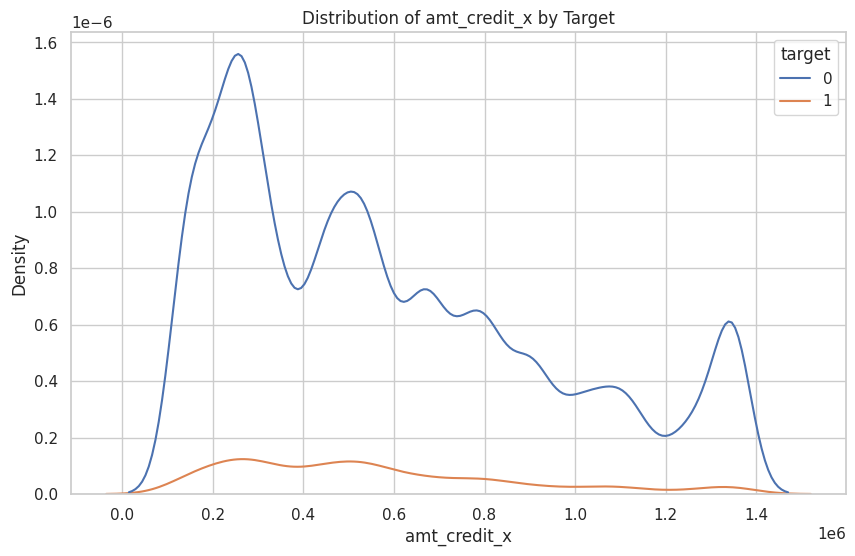

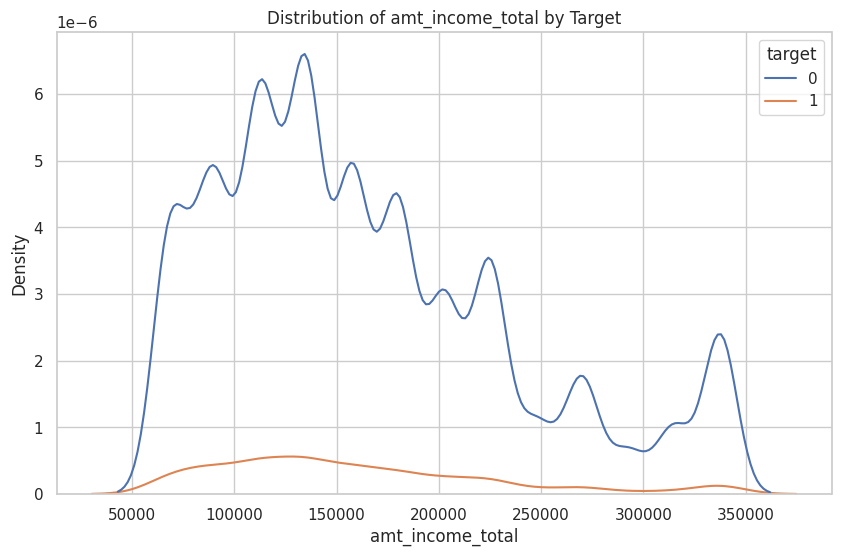

In [94]:
# 5. KDE Plots for Continuous Features
for feature in key_features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=loan_applications, x=feature, hue='target')
    plt.title(f'Distribution of {feature} by Target')
    plt.show()

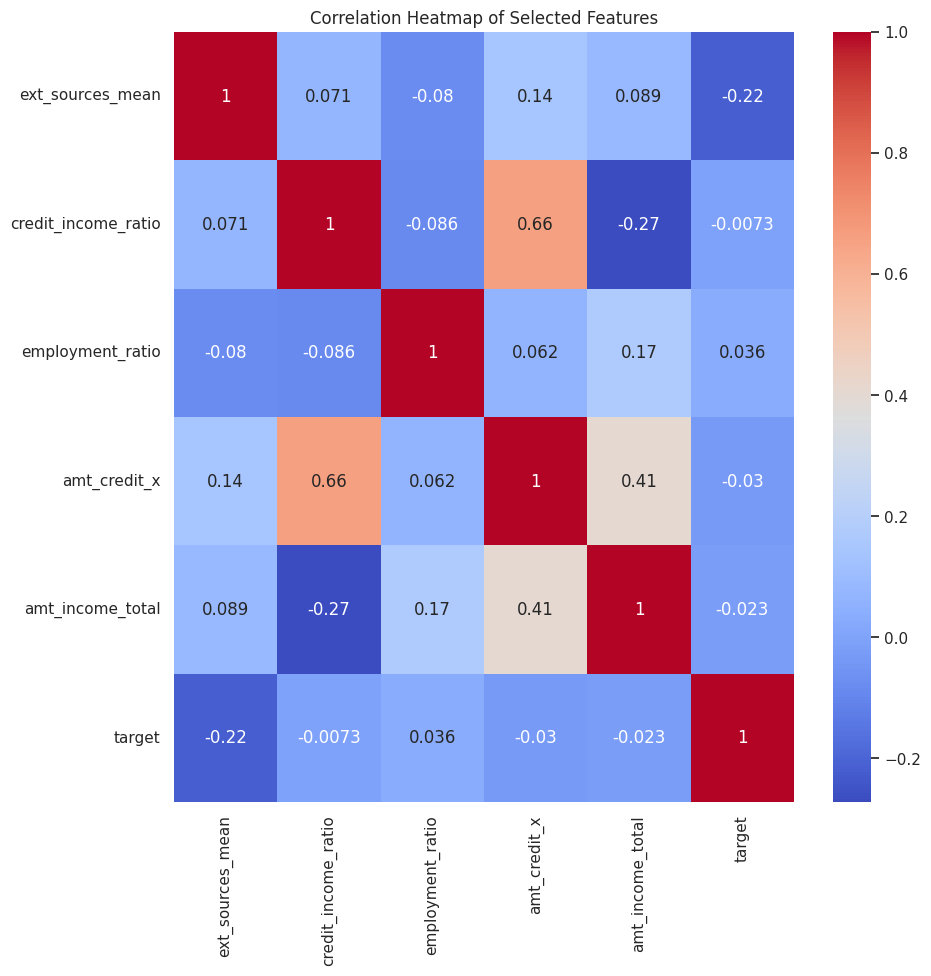

In [98]:
# 7. Heatmap of Selected Features
selected_features = key_features + ['target']
plt.figure(figsize=(10, 10))
sns.heatmap(loan_applications[selected_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Features')
plt.show()

In [99]:
# 2. Feature Importance using Random Forest
features = [col for col in loan_applications.columns if col != 'target' and col != 'sk_id_curr']
X = loan_applications[features]
y = loan_applications['target']

rf = RandomForestClassifier()
rf.fit(X, y)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 10))
sns.barplot(x=X.columns[indices][:20], y=importances[indices][:20])
plt.title('Top 20 Important Features')
plt.xticks(rotation=45)
plt.show()

ValueError: ignored